In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install pytorch-tabnet



Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s e

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import json
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

ModuleNotFoundError: No module named 'pytorch_tabnet'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def preprocess_csv(path):
    df = pd.read_csv(path, low_memory=False)
    move_mapping_pacman = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3}
    move_mapping_ghosts = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3, 'NEUTRAL': 4}

    df['PacmanMove'] = df['PacmanMove'].map(move_mapping_pacman)
    df['pacmanLastMoveMade'] = df['pacmanLastMoveMade'].map(move_mapping_pacman)

    for col in ['ghost1LastMove', 'ghost2LastMove', 'ghost3LastMove', 'ghost4LastMove']:
        df[col] = df[col].map(move_mapping_ghosts)

    # Eliminar filas con valores NaN o inválidos en columnas categóricas
    df.dropna(subset=['pacmanLastMoveMade', 'ghost1LastMove', 'ghost2LastMove', 'ghost3LastMove', 'ghost4LastMove'], inplace=True)

    # Asegurar que los valores estén dentro del rango válido
    df = df[(df['pacmanLastMoveMade'].between(0, 3)) &
            (df['ghost1LastMove'].between(0, 4)) &
            (df['ghost2LastMove'].between(0, 4)) &
            (df['ghost3LastMove'].between(0, 4)) &
            (df['ghost4LastMove'].between(0, 4))]

    grouped_df = df.groupby(['pacmanCurrentNodeIndex'])
    return grouped_df

In [ ]:
    dataset_path = "/content/drive/MyDrive/23_gameStatesData_enriched.csv"
    grouped_df = preprocess_csv(dataset_path)

In [ ]:
# CAMBIOS INCLUIDOS:
# 1. Eliminado OneHotEncoder para movimientos.
# 2. Se codifican los movimientos de Pac-Man y fantasmas como enteros.
# 3. Se preparan cat_idxs y cat_dims para TabNet.
# 4. Se pasa cat_idxs y cat_dims al TabNetClassifier.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import torch
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Columnas
columns_to_encode = ['ghost1LastMove', 'ghost2LastMove', 'ghost3LastMove', 'ghost4LastMove', 'pacmanLastMoveMade']
boolean_col = ['powerPill_0', 'powerPill_1', 'powerPill_2', 'powerPill_3'] + [f'pill_{i}' for i in range(220)]

# Escalado selectivo
...
# (Sin cambios en la función scale_selected_features y analyze_data_quality)
...

# Preprocesamiento completo
def scale_selected_features(X_df, exclude_cols, return_scaler=False):
    cols_to_scale = [col for col in X_df.columns if col not in exclude_cols]
    X_num = X_df[cols_to_scale]
    X_rest = X_df[exclude_cols]

    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)

    X_processed = np.hstack([X_num_scaled, X_rest.values])
    feature_names = cols_to_scale + list(X_rest.columns)

    if return_scaler:
        return X_processed, feature_names, scaler, cols_to_scale
    else:
        return X_processed, feature_names

def save_feature_importances(feature_names, importances, key):
    save_path = "/content/drive/MyDrive/modelos_tabnet_ini_4"
    os.makedirs(save_path, exist_ok=True)
    importancia_path = os.path.join(save_path, f"feature_importances_{key}.json")
    with open(importancia_path, "w") as f:
        json.dump({
            "features": feature_names,
            "importances": importances.tolist()
        }, f)
    print(f"Importancias guardadas en: {importancia_path}")

def save_scaler(scaler, columns, key):
    """
    Guarda el scaler y los nombres de columnas usados en el escalado.
    """
    save_path = "/content/drive/MyDrive/modelos_tabnet_ini_4"
    os.makedirs(save_path, exist_ok=True)
    scaler_path = os.path.join(save_path, f"scaler_{key}.pkl")

    # Guardar como diccionario
    joblib.dump({'scaler': scaler, 'columns': columns}, scaler_path)
    print(f"Scaler y columnas guardados en: {scaler_path}")


def save_model_tabnet(model, key):
    save_path = "/content/drive/MyDrive/modelos_tabnet_ini_4"
    os.makedirs(save_path, exist_ok=True)
    model.save_model(os.path.join(save_path, f"tabnet_model_{key}"))

# Análisis visual
def analyze_data_quality(X, feature_names=None):
    if feature_names:
        X_df = pd.DataFrame(X, columns=feature_names)
    else:
        X_df = pd.DataFrame(X)
    print("\nEstadísticas generales de las características:")
    print(X_df.describe().T)
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=X_df)
    plt.xticks(rotation=90)
    plt.title("Distribución y Outliers de las Características (Normalizadas)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
    correlation_matrix = X_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
    plt.title("Mapa de Correlación entre Variables")
    plt.show()
    print("\nVariables con correlación > 0.90 (posible redundancia):")
    threshold = 0.9
    already_reported = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                pair = tuple(sorted((var1, var2)))
                if pair not in already_reported:
                    already_reported.add(pair)
                    print(f"{var1} ⬌ {var2} → correlación = {corr_value:.2f}")


# Entrenamiento TabNet

def train_tabnet_nn(X_train, y_train, X_cv, y_cv, key, cat_idxs=None, cat_dims=None, max_epochs=400, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Usando dispositivo: {device}")
    clf = TabNetClassifier(
        n_d=128, n_a=128, n_steps=12, gamma=1.5, lambda_sparse=0.003,
        momentum=0.3, clip_value=2.0,
        optimizer_fn=torch.optim.AdamW,
        optimizer_params={"lr": 2e-4, "weight_decay": 1e-5},
        scheduler_params={"step_size": 15, "gamma": 0.85},
        device_name=device,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=3,
        mask_type='entmax'
    )
    clf.fit(
        X_train, y_train,
        eval_set=[(X_cv, y_cv)],
        max_epochs=max_epochs, patience=40,
        batch_size=4096, virtual_batch_size=2048,
        weights=weights
    )
    save_path = "/content/drive/MyDrive/modelos_tabnet_ini_4"
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, f"tabnet_classes_{key}.json"), "w") as f:
        json.dump(np.unique(y_train).tolist(), f)
    return clf

# Main

def main(grouped_df):

    for key, group in grouped_df:
        print(f"\nProcesando grupo: {key}")

        abs_rewards = group["reward"].abs()
        if abs_rewards.max() != abs_rewards.min():
            reward_weights  = (abs_rewards - abs_rewards.min()) / (abs_rewards.max() - abs_rewards.min())
        else:
            reward_weights  = pd.Series(1.0, index=abs_rewards.index)

        class_freq = group['PacmanMove'].value_counts(normalize=True)
        class_weight = group['PacmanMove'].map(lambda c: 1 / class_freq[c])

        sample_weight = reward_weights * class_weight

        X_df = group.drop(columns=["PacmanMove", "reward", "pacmanCurrentNodeIndex", "pillWasEaten"])
        Y = group["PacmanMove"].values
        all_feature_names = X_df.columns.tolist()

        class_counts = Counter(Y)
        valid_classes = {cls for cls, count in class_counts.items() if count >= 100}
        mask = np.isin(Y, list(valid_classes))
        X_df = X_df[mask]
        Y = Y[mask]
        sample_weight = sample_weight[mask].values

        if len(Y) < 10 or len(valid_classes) < 2:
            print(f"Grupo {key} ignorado por falta de datos/clases válidas.")
            continue

        stratify_option = Y if min(Counter(Y).values()) >= 2 else None
        X_train_df, X_temp_df, y_train, y_temp, sw_train, sw_temp = train_test_split(
            X_df, Y, sample_weight, test_size=0.30, random_state=1, stratify=stratify_option)

        stratify_option = y_temp if min(Counter(y_temp).values()) >= 2 else None
        X_cv_df, X_test_df, y_cv, y_test, sw_cv, sw_test = train_test_split(
            X_temp_df, y_temp, sw_temp, test_size=0.33, random_state=1, stratify=stratify_option)

        categorical_cols = ['ghost1LastMove', 'ghost2LastMove', 'ghost3LastMove', 'ghost4LastMove', 'pacmanLastMoveMade', 'pacmanMode']
        columns_no_scale = categorical_cols + boolean_col

        X_train, feature_names, scaler, cols_to_scale = scale_selected_features(X_train_df, columns_no_scale, return_scaler=True)
        X_cv, _ = scale_selected_features(X_cv_df, columns_no_scale)
        X_test, _ = scale_selected_features(X_test_df, columns_no_scale)

        cat_idxs = [feature_names.index(col) for col in categorical_cols]
        cat_dims = [5, 5, 5, 5, 4, 3]

        save_scaler(scaler, cols_to_scale, key)

        print("Clases únicas en y_train:", Counter(y_train))
        print("Clases únicas en y_test:", Counter(y_test))

        analyze_data_quality(X_train, feature_names)

        model = train_tabnet_nn(X_train, y_train, X_cv, y_cv, key, cat_idxs=cat_idxs, cat_dims=cat_dims, weights=sw_train)

        y_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred, sample_weight=sw_test)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        print(f"Balanced Accuracy Score: {balanced_acc:.5f}")
        print(f"\nPrecisión en test para grupo {key}: {test_accuracy:.5f}")

        print("\nReporte sin pesos (clásico):")
        print(classification_report(y_test, y_pred))

        print("\nReporte con pesos (ponderado por reward):")
        print(classification_report(y_test, y_pred, sample_weight=sw_test))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicho")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusión - Grupo {key}")
        plt.show()

        print("\nDistribución de movimientos:")
        print("Reales:   ", Counter(y_test))
        print("Predichos:", Counter(y_pred))

        y_probs = model.predict_proba(X_test)
        print("\nPrimeras 5 predicciones con probabilidades:")
        print(y_probs[:5])

        feature_importance = model.feature_importances_
        save_feature_importances(feature_names, feature_importance, key)
        save_model_tabnet(model, key)

        print("\nResumen del grupo:")
        print(f"Nº muestras totales: {len(Y)}")
        print(f"Clases entrenadas: {sorted(list(valid_classes))}")
        print(f"Accuracy test: {test_accuracy:.4f}")
        print("─"*44)



🟨 Procesando grupo: (153,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(153,).pkl
📊 Clases únicas en y_train: Counter({np.int64(3): 49633, np.int64(1): 39471, np.int64(2): 18193})
📊 Clases únicas en y_test: Counter({np.int64(3): 7020, np.int64(1): 5583, np.int64(2): 2573})
🖥️ Usando dispositivo: cuda


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.63333 | val_0_accuracy: 0.34698 |  0:00:04s
epoch 1  | loss: 3.02093 | val_0_accuracy: 0.36853 |  0:00:08s
epoch 2  | loss: 2.8772  | val_0_accuracy: 0.37018 |  0:00:12s
epoch 3  | loss: 2.75973 | val_0_accuracy: 0.37642 |  0:00:17s
epoch 4  | loss: 2.62472 | val_0_accuracy: 0.38275 |  0:00:21s
epoch 5  | loss: 2.50412 | val_0_accuracy: 0.37324 |  0:00:25s
epoch 6  | loss: 2.36087 | val_0_accuracy: 0.40079 |  0:00:29s
epoch 7  | loss: 2.25462 | val_0_accuracy: 0.40657 |  0:00:34s
epoch 8  | loss: 2.16248 | val_0_accuracy: 0.41718 |  0:00:38s
epoch 9  | loss: 2.0918  | val_0_accuracy: 0.42546 |  0:00:42s
epoch 10 | loss: 1.97769 | val_0_accuracy: 0.42478 |  0:00:46s
epoch 11 | loss: 1.86257 | val_0_accuracy: 0.4376  |  0:00:51s
epoch 12 | loss: 1.7812  | val_0_accuracy: 0.45214 |  0:00:55s
epoch 13 | loss: 1.73255 | val_0_accuracy: 0.4537  |  0:00:59s
epoch 14 | loss: 1.66287 | val_0_accuracy: 0.45853 |  0:01:03s
epoch 15 | loss: 1.57168 | val_0_accuracy: 0.4733  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.80557

✅ Precisión en test para grupo (153,): 0.85889

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.81      0.70      0.75      5583
           2       0.82      0.87      0.84      2573
           3       0.78      0.85      0.81      7020

    accuracy                           0.80     15176
   macro avg       0.80      0.81      0.80     15176
weighted avg       0.80      0.80      0.80     15176


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.79      0.76      0.77 786.657365042224
           2       0.92      0.87      0.89 721.9137937668476
           3       0.86      0.90      0.88 1622.3454247997147

    accuracy                           0.86 3130.9165836087864
   macro avg       0.86      0.84      0.85 3130.9165836087864
weighted avg       0.86      0.86      0.86 3130.9165836087864



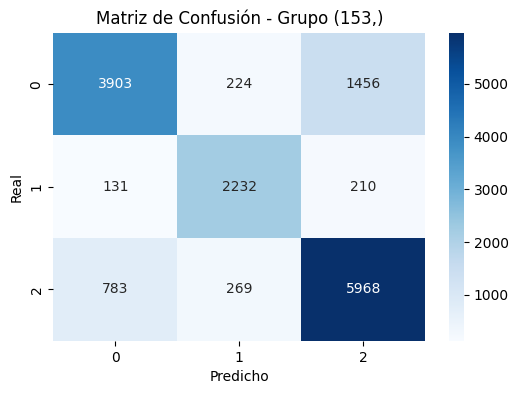


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 7020, np.int64(1): 5583, np.int64(2): 2573})
🔵 Predichos: Counter({np.int64(3): 7634, np.int64(1): 4817, np.int64(2): 2725})

🔍 Primeras 5 predicciones con probabilidades:
[[0.59339136 0.00470045 0.40190822]
 [0.1445979  0.02099817 0.834404  ]
 [0.04984293 0.2927998  0.6573573 ]
 [0.18703301 0.02697965 0.7859874 ]
 [0.16606165 0.00846362 0.82547474]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(153,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(153,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 153282
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8589
────────────────────────────────────────────

🟨 Procesando grupo: (165,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(165,).pkl
📊 Clases únicas en y_train: Counter({np.int64(3): 44948, np.int64(1): 360

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.6925  | val_0_accuracy: 0.2378  |  0:00:05s
epoch 1  | loss: 6.32485 | val_0_accuracy: 0.21849 |  0:00:10s
epoch 2  | loss: 5.07527 | val_0_accuracy: 0.23993 |  0:00:16s
epoch 3  | loss: 4.13295 | val_0_accuracy: 0.26286 |  0:00:21s
epoch 4  | loss: 3.6045  | val_0_accuracy: 0.27956 |  0:00:27s
epoch 5  | loss: 3.40839 | val_0_accuracy: 0.2777  |  0:00:32s
epoch 6  | loss: 3.27459 | val_0_accuracy: 0.28628 |  0:00:38s
epoch 7  | loss: 3.15575 | val_0_accuracy: 0.30543 |  0:00:43s
epoch 8  | loss: 3.03449 | val_0_accuracy: 0.30591 |  0:00:49s
epoch 9  | loss: 2.8997  | val_0_accuracy: 0.31845 |  0:00:54s
epoch 10 | loss: 2.74933 | val_0_accuracy: 0.32425 |  0:00:59s
epoch 11 | loss: 2.61384 | val_0_accuracy: 0.33158 |  0:01:05s
epoch 12 | loss: 2.43801 | val_0_accuracy: 0.33344 |  0:01:10s
epoch 13 | loss: 2.33184 | val_0_accuracy: 0.34695 |  0:01:15s
epoch 14 | loss: 2.19816 | val_0_accuracy: 0.3637  |  0:01:21s
epoch 15 | loss: 2.06784 | val_0_accuracy: 0.37556 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.65929

✅ Precisión en test para grupo (165,): 0.76201

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      3873
           1       0.63      0.54      0.58      5096
           2       0.60      0.66      0.63      5054
           3       0.63      0.69      0.66      6357

    accuracy                           0.66     20380
   macro avg       0.67      0.66      0.66     20380
weighted avg       0.66      0.66      0.66     20380


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.89      0.84      0.87 697.898258286952
           1       0.79      0.73      0.76 1149.313785664096
           2       0.70      0.71      0.70 1065.5320460137611
           3       0.73      0.79      0.76 1396.9306177819133

    accuracy                           0.76 4309.674707746723
   macro avg       0.78      0.77    

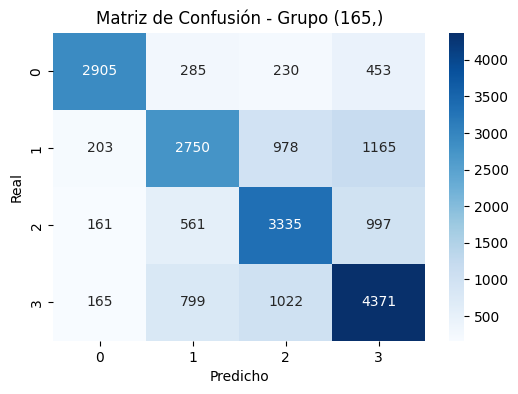


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 6357, np.int64(1): 5096, np.int64(2): 5054, np.int64(0): 3873})
🔵 Predichos: Counter({np.int64(3): 6986, np.int64(2): 5565, np.int64(1): 4395, np.int64(0): 3434})

🔍 Primeras 5 predicciones con probabilidades:
[[1.1554190e-02 1.8912563e-02 3.9621720e-01 5.7331598e-01]
 [1.3705299e-03 1.7608875e-01 7.7039987e-02 7.4550068e-01]
 [4.4917785e-02 9.2943645e-01 4.3051937e-03 2.1340590e-02]
 [9.9839932e-01 2.3182681e-04 6.5888191e-04 7.1002089e-04]
 [1.1556355e-02 1.1080010e-01 2.7446267e-01 6.0318089e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(165,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(165,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 205850
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7620
────────────────────────────────────────────

🟨 Procesando grupo: (177,)
✅ S

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.76751 | val_0_accuracy: 0.34272 |  0:00:04s
epoch 1  | loss: 3.18139 | val_0_accuracy: 0.406   |  0:00:08s
epoch 2  | loss: 2.94735 | val_0_accuracy: 0.40839 |  0:00:12s
epoch 3  | loss: 2.82535 | val_0_accuracy: 0.41206 |  0:00:16s
epoch 4  | loss: 2.73623 | val_0_accuracy: 0.40804 |  0:00:20s
epoch 5  | loss: 2.68838 | val_0_accuracy: 0.41733 |  0:00:25s
epoch 6  | loss: 2.66313 | val_0_accuracy: 0.39553 |  0:00:29s
epoch 7  | loss: 2.53741 | val_0_accuracy: 0.4007  |  0:00:33s
epoch 8  | loss: 2.39489 | val_0_accuracy: 0.42768 |  0:00:37s
epoch 9  | loss: 2.28463 | val_0_accuracy: 0.40804 |  0:00:42s
epoch 10 | loss: 2.17519 | val_0_accuracy: 0.41849 |  0:00:46s
epoch 11 | loss: 2.10662 | val_0_accuracy: 0.41441 |  0:00:50s
epoch 12 | loss: 2.04669 | val_0_accuracy: 0.43506 |  0:00:54s
epoch 13 | loss: 1.91499 | val_0_accuracy: 0.43252 |  0:00:58s
epoch 14 | loss: 1.7718  | val_0_accuracy: 0.45818 |  0:01:03s
epoch 15 | loss: 1.71349 | val_0_accuracy: 0.46204 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.74206

✅ Precisión en test para grupo (177,): 0.79678

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      2747
           2       0.82      0.85      0.84      7647
           3       0.75      0.76      0.75      5306

    accuracy                           0.78     15700
   macro avg       0.76      0.74      0.75     15700
weighted avg       0.78      0.78      0.78     15700


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.81      0.66      0.73 364.97732035410814
           2       0.80      0.85      0.83 957.4896399309953
           3       0.79      0.79      0.79 830.7542674930755

    accuracy                           0.80 2153.221227778179
   macro avg       0.80      0.77      0.78 2153.221227778179
weighted avg       0.80      0.80      0.80 2153.221227778179



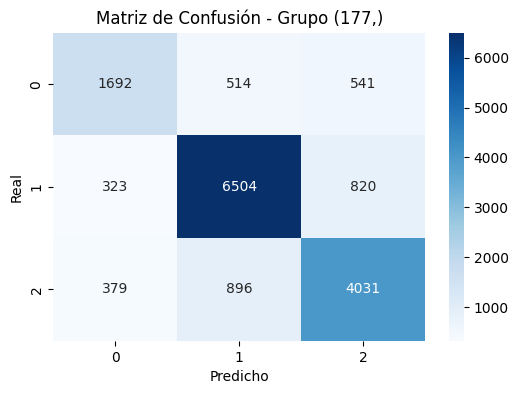


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 7647, np.int64(3): 5306, np.int64(0): 2747})
🔵 Predichos: Counter({np.int64(2): 7914, np.int64(3): 5392, np.int64(0): 2394})

🔍 Primeras 5 predicciones con probabilidades:
[[0.30686224 0.56757176 0.12556602]
 [0.00116174 0.4220566  0.5767817 ]
 [0.07424373 0.4019067  0.52384955]
 [0.06056041 0.9379401  0.00149954]
 [0.17132685 0.5003587  0.32831445]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(177,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(177,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 158580
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7968
────────────────────────────────────────────

🟨 Procesando grupo: (189,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(189,).pkl
📊 Clases únicas en y_train: Counter({np.int64(2): 49320, np.int64(3): 472

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.74038 | val_0_accuracy: 0.35303 |  0:00:04s
epoch 1  | loss: 3.1567  | val_0_accuracy: 0.37344 |  0:00:08s
epoch 2  | loss: 3.0683  | val_0_accuracy: 0.37646 |  0:00:13s
epoch 3  | loss: 2.98032 | val_0_accuracy: 0.38173 |  0:00:17s
epoch 4  | loss: 2.9176  | val_0_accuracy: 0.38817 |  0:00:22s
epoch 5  | loss: 2.81872 | val_0_accuracy: 0.39122 |  0:00:26s
epoch 6  | loss: 2.70657 | val_0_accuracy: 0.39367 |  0:00:31s
epoch 7  | loss: 2.55537 | val_0_accuracy: 0.39107 |  0:00:35s
epoch 8  | loss: 2.41929 | val_0_accuracy: 0.38858 |  0:00:40s
epoch 9  | loss: 2.35777 | val_0_accuracy: 0.38924 |  0:00:44s
epoch 10 | loss: 2.27481 | val_0_accuracy: 0.37898 |  0:00:48s
epoch 11 | loss: 2.16939 | val_0_accuracy: 0.39846 |  0:00:53s
epoch 12 | loss: 2.03051 | val_0_accuracy: 0.40421 |  0:00:57s
epoch 13 | loss: 1.94272 | val_0_accuracy: 0.39143 |  0:01:02s
epoch 14 | loss: 1.87017 | val_0_accuracy: 0.40463 |  0:01:06s
epoch 15 | loss: 1.81977 | val_0_accuracy: 0.41292 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.65466

✅ Precisión en test para grupo (189,): 0.79464

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.62      0.53      0.57      2799
           2       0.70      0.73      0.71      6975
           3       0.70      0.70      0.70      6683

    accuracy                           0.68     16457
   macro avg       0.67      0.65      0.66     16457
weighted avg       0.68      0.68      0.68     16457


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.87      0.64      0.74 683.0495141511751
           2       0.76      0.84      0.80 1289.2387494985514
           3       0.80      0.83      0.81 1316.9406867613413

    accuracy                           0.79 3289.2289504110677
   macro avg       0.81      0.77      0.78 3289.2289504110677
weighted avg       0.80      0.79      0.79 3289.2289504110677



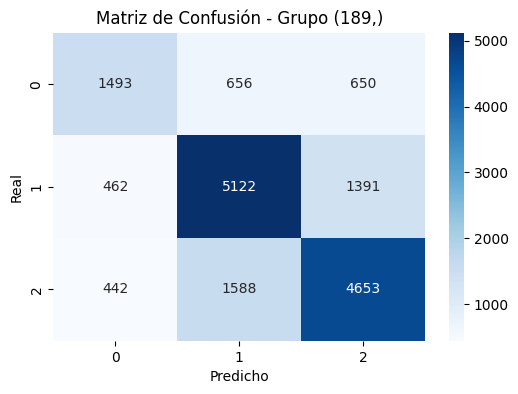


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 6975, np.int64(3): 6683, np.int64(1): 2799})
🔵 Predichos: Counter({np.int64(2): 7366, np.int64(3): 6694, np.int64(1): 2397})

🔍 Primeras 5 predicciones con probabilidades:
[[1.00352034e-01 3.67002249e-01 5.32645702e-01]
 [7.89784099e-06 1.11340415e-02 9.88858104e-01]
 [4.75175194e-02 2.40456417e-01 7.12026060e-01]
 [4.85242493e-02 4.60613184e-02 9.05414462e-01]
 [2.92909390e-05 1.17248436e-03 9.98798251e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(189,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(189,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 166224
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7946
────────────────────────────────────────────

🟨 Procesando grupo: (201,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(201,).pkl
📊 Clases únic

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.4766  | val_0_accuracy: 0.3511  |  0:00:04s
epoch 1  | loss: 3.0662  | val_0_accuracy: 0.36614 |  0:00:08s
epoch 2  | loss: 2.93637 | val_0_accuracy: 0.35814 |  0:00:13s
epoch 3  | loss: 2.89468 | val_0_accuracy: 0.38669 |  0:00:17s
epoch 4  | loss: 2.77595 | val_0_accuracy: 0.36507 |  0:00:21s
epoch 5  | loss: 2.72641 | val_0_accuracy: 0.36993 |  0:00:26s
epoch 6  | loss: 2.6427  | val_0_accuracy: 0.38482 |  0:00:30s
epoch 7  | loss: 2.55333 | val_0_accuracy: 0.37995 |  0:00:35s
epoch 8  | loss: 2.43525 | val_0_accuracy: 0.3872  |  0:00:39s
epoch 9  | loss: 2.38838 | val_0_accuracy: 0.39141 |  0:00:44s
epoch 10 | loss: 2.26892 | val_0_accuracy: 0.38267 |  0:00:48s
epoch 11 | loss: 2.14471 | val_0_accuracy: 0.39842 |  0:00:52s
epoch 12 | loss: 2.04877 | val_0_accuracy: 0.42461 |  0:00:57s
epoch 13 | loss: 1.97353 | val_0_accuracy: 0.40561 |  0:01:01s
epoch 14 | loss: 1.91182 | val_0_accuracy: 0.41396 |  0:01:06s
epoch 15 | loss: 1.77879 | val_0_accuracy: 0.41641 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.73777

✅ Precisión en test para grupo (201,): 0.78382

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.63      0.65      0.64      3194
           2       0.79      0.75      0.77      6307
           3       0.78      0.81      0.80      7009

    accuracy                           0.76     16510
   macro avg       0.74      0.74      0.74     16510
weighted avg       0.76      0.76      0.76     16510


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.82      0.74      0.77 880.2088934665968
           2       0.77      0.78      0.77 1072.4976513982974
           3       0.77      0.83      0.80 1127.9280204353338

    accuracy                           0.78 3080.634565300228
   macro avg       0.79      0.78      0.78 3080.634565300228
weighted avg       0.79      0.78      0.78 3080.634565300228



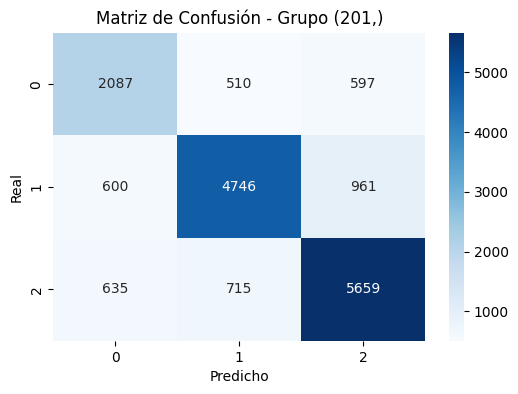


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 7009, np.int64(2): 6307, np.int64(1): 3194})
🔵 Predichos: Counter({np.int64(3): 7217, np.int64(2): 5971, np.int64(1): 3322})

🔍 Primeras 5 predicciones con probabilidades:
[[7.3027052e-02 2.9363697e-02 8.9760935e-01]
 [1.4730702e-01 6.8339698e-02 7.8435326e-01]
 [8.4593669e-02 4.0752181e-01 5.0788450e-01]
 [2.2816291e-04 9.7817904e-01 2.1592867e-02]
 [2.6524106e-01 6.7213434e-01 6.2624626e-02]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(201,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(201,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 166765
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7838
────────────────────────────────────────────

🟨 Procesando grupo: (213,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(213,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.79319 | val_0_accuracy: 0.33339 |  0:00:03s
epoch 1  | loss: 3.36486 | val_0_accuracy: 0.34295 |  0:00:07s
epoch 2  | loss: 3.09306 | val_0_accuracy: 0.38214 |  0:00:11s
epoch 3  | loss: 2.9538  | val_0_accuracy: 0.38457 |  0:00:15s
epoch 4  | loss: 2.88368 | val_0_accuracy: 0.37899 |  0:00:19s
epoch 5  | loss: 2.78181 | val_0_accuracy: 0.38878 |  0:00:22s
epoch 6  | loss: 2.7304  | val_0_accuracy: 0.38379 |  0:00:26s
epoch 7  | loss: 2.62548 | val_0_accuracy: 0.38277 |  0:00:30s
epoch 8  | loss: 2.53792 | val_0_accuracy: 0.38273 |  0:00:34s
epoch 9  | loss: 2.42278 | val_0_accuracy: 0.38717 |  0:00:38s
epoch 10 | loss: 2.31506 | val_0_accuracy: 0.38303 |  0:00:42s
epoch 11 | loss: 2.2027  | val_0_accuracy: 0.39513 |  0:00:46s
epoch 12 | loss: 2.13414 | val_0_accuracy: 0.38513 |  0:00:49s
epoch 13 | loss: 2.08095 | val_0_accuracy: 0.38878 |  0:00:53s
epoch 14 | loss: 2.09673 | val_0_accuracy: 0.40473 |  0:00:57s
epoch 15 | loss: 2.00601 | val_0_accuracy: 0.37668 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.64244

✅ Precisión en test para grupo (213,): 0.79074

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      3050
           2       0.66      0.71      0.68      5546
           3       0.72      0.71      0.72      6387

    accuracy                           0.67     14983
   macro avg       0.65      0.64      0.64     14983
weighted avg       0.67      0.67      0.67     14983


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.77      0.66      0.71 567.7140188191019
           2       0.74      0.79      0.76 837.7281792388668
           3       0.84      0.85      0.84 1188.377049324681

    accuracy                           0.79 2593.8192473826493
   macro avg       0.78      0.77      0.77 2593.8192473826493
weighted avg       0.79      0.79      0.79 2593.8192473826493



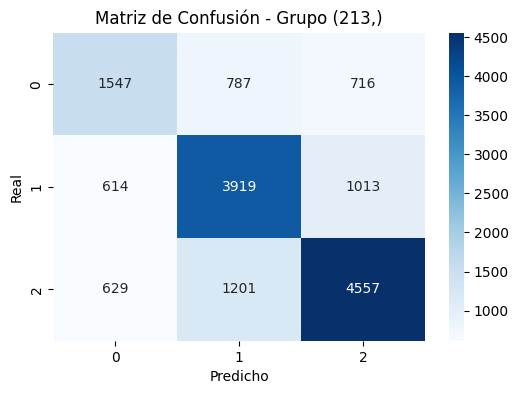


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 6387, np.int64(2): 5546, np.int64(0): 3050})
🔵 Predichos: Counter({np.int64(3): 6286, np.int64(2): 5907, np.int64(0): 2790})

🔍 Primeras 5 predicciones con probabilidades:
[[0.07302888 0.5408275  0.38614357]
 [0.06175811 0.8535573  0.08468466]
 [0.3589246  0.6040473  0.03702813]
 [0.25788438 0.5945567  0.14755894]
 [0.09696735 0.0197513  0.88328135]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(213,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(213,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 151334
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7907
────────────────────────────────────────────

🟨 Procesando grupo: (225,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(225,).pkl
📊 Clases únicas en y_train: Counter({np.int64(2): 43540, np.int64(3): 420

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.27779 | val_0_accuracy: 0.24548 |  0:00:04s
epoch 1  | loss: 6.09901 | val_0_accuracy: 0.24255 |  0:00:09s
epoch 2  | loss: 4.88306 | val_0_accuracy: 0.24877 |  0:00:14s
epoch 3  | loss: 3.96844 | val_0_accuracy: 0.26851 |  0:00:19s
epoch 4  | loss: 3.57668 | val_0_accuracy: 0.2872  |  0:00:24s
epoch 5  | loss: 3.43694 | val_0_accuracy: 0.2782  |  0:00:29s
epoch 6  | loss: 3.30002 | val_0_accuracy: 0.2937  |  0:00:34s
epoch 7  | loss: 3.19021 | val_0_accuracy: 0.2937  |  0:00:39s
epoch 8  | loss: 3.05155 | val_0_accuracy: 0.30082 |  0:00:44s
epoch 9  | loss: 2.90393 | val_0_accuracy: 0.31354 |  0:00:49s
epoch 10 | loss: 2.80625 | val_0_accuracy: 0.3127  |  0:00:54s
epoch 11 | loss: 2.57848 | val_0_accuracy: 0.32879 |  0:00:59s
epoch 12 | loss: 2.40403 | val_0_accuracy: 0.33239 |  0:01:04s
epoch 13 | loss: 2.25865 | val_0_accuracy: 0.33563 |  0:01:09s
epoch 14 | loss: 2.11666 | val_0_accuracy: 0.34565 |  0:01:14s
epoch 15 | loss: 2.00224 | val_0_accuracy: 0.36439 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.64886

✅ Precisión en test para grupo (225,): 0.80147

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3630
           1       0.58      0.55      0.56      3586
           2       0.65      0.72      0.68      6158
           3       0.63      0.59      0.61      5941

    accuracy                           0.65     19315
   macro avg       0.65      0.65      0.65     19315
weighted avg       0.65      0.65      0.65     19315


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.91      0.87      0.89 1292.2907571827993
           1       0.75      0.72      0.73 1167.6842425513455
           2       0.79      0.82      0.81 1798.032544293105
           3       0.78      0.78      0.78 1674.7586146185085

    accuracy                           0.80 5932.766158645759
   macro avg       0.80      0.80  

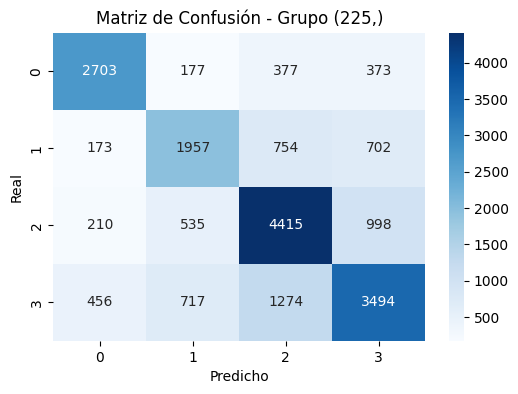


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 6158, np.int64(3): 5941, np.int64(0): 3630, np.int64(1): 3586})
🔵 Predichos: Counter({np.int64(2): 6820, np.int64(3): 5567, np.int64(0): 3542, np.int64(1): 3386})

🔍 Primeras 5 predicciones con probabilidades:
[[0.03607979 0.5003947  0.2950512  0.16847436]
 [0.04292668 0.00942226 0.84739894 0.10025205]
 [0.10745228 0.43486452 0.25540537 0.20227781]
 [0.02034102 0.00833718 0.7806829  0.19063891]
 [0.01600214 0.02766253 0.26254278 0.6937925 ]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(225,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(225,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 195091
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8015
────────────────────────────────────────────

🟨 Procesando grupo: (237,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.49712 | val_0_accuracy: 0.3567  |  0:00:03s
epoch 1  | loss: 3.01661 | val_0_accuracy: 0.34654 |  0:00:07s
epoch 2  | loss: 2.89863 | val_0_accuracy: 0.35483 |  0:00:11s
epoch 3  | loss: 2.77221 | val_0_accuracy: 0.36452 |  0:00:15s
epoch 4  | loss: 2.73567 | val_0_accuracy: 0.37715 |  0:00:19s
epoch 5  | loss: 2.62536 | val_0_accuracy: 0.37395 |  0:00:23s
epoch 6  | loss: 2.49783 | val_0_accuracy: 0.3724  |  0:00:26s
epoch 7  | loss: 2.4148  | val_0_accuracy: 0.38123 |  0:00:30s
epoch 8  | loss: 2.35902 | val_0_accuracy: 0.39145 |  0:00:34s
epoch 9  | loss: 2.27474 | val_0_accuracy: 0.39845 |  0:00:38s
epoch 10 | loss: 2.2664  | val_0_accuracy: 0.40009 |  0:00:42s
epoch 11 | loss: 2.1336  | val_0_accuracy: 0.41247 |  0:00:46s
epoch 12 | loss: 2.01633 | val_0_accuracy: 0.40298 |  0:00:50s
epoch 13 | loss: 1.95889 | val_0_accuracy: 0.42045 |  0:00:54s
epoch 14 | loss: 1.87331 | val_0_accuracy: 0.41301 |  0:00:58s
epoch 15 | loss: 1.76137 | val_0_accuracy: 0.43361 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.76349

✅ Precisión en test para grupo (237,): 0.86737

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.82      0.69      0.75      6619
           2       0.68      0.81      0.74      5659
           3       0.82      0.79      0.80      3284

    accuracy                           0.76     15562
   macro avg       0.77      0.76      0.76     15562
weighted avg       0.77      0.76      0.76     15562


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.85      0.84      0.85 1170.0637951575382
           2       0.86      0.89      0.88 1592.8650497149779
           3       0.91      0.86      0.88 622.4427976489043

    accuracy                           0.87 3385.37164252142
   macro avg       0.88      0.86      0.87 3385.37164252142
weighted avg       0.87      0.87      0.87 3385.37164252142



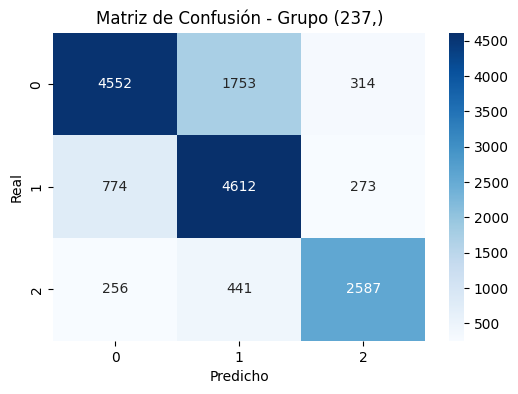


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 6619, np.int64(2): 5659, np.int64(3): 3284})
🔵 Predichos: Counter({np.int64(2): 6806, np.int64(1): 5582, np.int64(3): 3174})

🔍 Primeras 5 predicciones con probabilidades:
[[0.5720696  0.11234866 0.31558174]
 [0.06993181 0.9092935  0.02077475]
 [0.1065743  0.8526586  0.04076707]
 [0.9922693  0.005074   0.00265678]
 [0.7627381  0.03696555 0.20029634]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(237,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(237,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 157189
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8674
────────────────────────────────────────────

🟨 Procesando grupo: (348,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(348,).pkl
📊 Clases únicas en y_train: Counter({np.int64(0): 43423, np.int64(1): 363

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.50593 | val_0_accuracy: 0.32566 |  0:00:03s
epoch 1  | loss: 3.09843 | val_0_accuracy: 0.32308 |  0:00:07s
epoch 2  | loss: 3.0272  | val_0_accuracy: 0.33052 |  0:00:10s
epoch 3  | loss: 2.89913 | val_0_accuracy: 0.32784 |  0:00:14s
epoch 4  | loss: 2.86074 | val_0_accuracy: 0.33059 |  0:00:17s
epoch 5  | loss: 2.74315 | val_0_accuracy: 0.33864 |  0:00:21s
epoch 6  | loss: 2.6839  | val_0_accuracy: 0.32477 |  0:00:24s
epoch 7  | loss: 2.66307 | val_0_accuracy: 0.34513 |  0:00:28s
epoch 8  | loss: 2.58775 | val_0_accuracy: 0.34724 |  0:00:32s
epoch 9  | loss: 2.52872 | val_0_accuracy: 0.35123 |  0:00:35s
epoch 10 | loss: 2.40074 | val_0_accuracy: 0.34569 |  0:00:39s
epoch 11 | loss: 2.32898 | val_0_accuracy: 0.36975 |  0:00:43s
epoch 12 | loss: 2.22583 | val_0_accuracy: 0.36097 |  0:00:46s
epoch 13 | loss: 2.14997 | val_0_accuracy: 0.38312 |  0:00:50s
epoch 14 | loss: 2.04931 | val_0_accuracy: 0.36964 |  0:00:53s
epoch 15 | loss: 1.96804 | val_0_accuracy: 0.38647 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.73397

✅ Precisión en test para grupo (348,): 0.76497

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6141
           1       0.78      0.75      0.76      5147
           2       0.58      0.65      0.61      2675

    accuracy                           0.75     13963
   macro avg       0.73      0.73      0.73     13963
weighted avg       0.76      0.75      0.76     13963


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.75      0.84      0.79 545.3808488043352
           1       0.75      0.76      0.76 634.2802330073283
           2       0.79      0.71      0.75 662.7324056815409

    accuracy                           0.76 1842.3934874932042
   macro avg       0.77      0.77      0.77 1842.3934874932042
weighted avg       0.77      0.76      0.76 1842.3934874932042



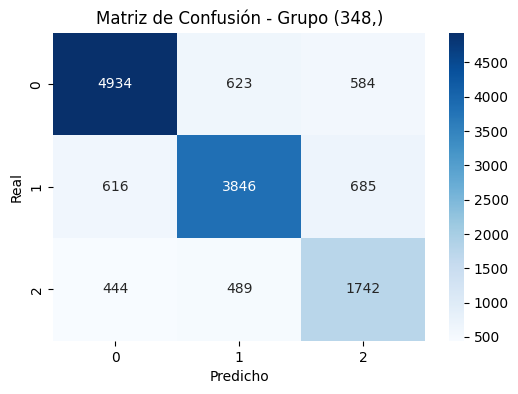


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 6141, np.int64(1): 5147, np.int64(2): 2675})
🔵 Predichos: Counter({np.int64(0): 5994, np.int64(1): 4958, np.int64(2): 3011})

🔍 Primeras 5 predicciones con probabilidades:
[[2.1643463e-01 5.5253172e-01 2.3103364e-01]
 [5.8654511e-01 2.6542589e-01 1.4802897e-01]
 [2.8117046e-01 4.5377940e-01 2.6505017e-01]
 [1.1524906e-02 9.8776734e-01 7.0778053e-04]
 [4.2953048e-02 6.6364038e-01 2.9340655e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(348,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(348,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 141039
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2)]
🎯 Accuracy test: 0.7650
────────────────────────────────────────────

🟨 Procesando grupo: (361,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(361,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.36839 | val_0_accuracy: 0.34886 |  0:00:03s
epoch 1  | loss: 3.18259 | val_0_accuracy: 0.33604 |  0:00:06s
epoch 2  | loss: 3.10655 | val_0_accuracy: 0.34206 |  0:00:10s
epoch 3  | loss: 2.95417 | val_0_accuracy: 0.33861 |  0:00:13s
epoch 4  | loss: 2.84831 | val_0_accuracy: 0.34217 |  0:00:16s
epoch 5  | loss: 2.7882  | val_0_accuracy: 0.34061 |  0:00:19s
epoch 6  | loss: 2.69883 | val_0_accuracy: 0.35179 |  0:00:23s
epoch 7  | loss: 2.58298 | val_0_accuracy: 0.36858 |  0:00:26s
epoch 8  | loss: 2.47494 | val_0_accuracy: 0.35019 |  0:00:29s
epoch 9  | loss: 2.3418  | val_0_accuracy: 0.35261 |  0:00:33s
epoch 10 | loss: 2.29056 | val_0_accuracy: 0.36401 |  0:00:36s
epoch 11 | loss: 2.17657 | val_0_accuracy: 0.36186 |  0:00:40s
epoch 12 | loss: 2.14317 | val_0_accuracy: 0.39016 |  0:00:43s
epoch 13 | loss: 2.08247 | val_0_accuracy: 0.37879 |  0:00:46s
epoch 14 | loss: 1.99491 | val_0_accuracy: 0.39335 |  0:00:50s
epoch 15 | loss: 1.97513 | val_0_accuracy: 0.39543 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.67422

✅ Precisión en test para grupo (361,): 0.76001

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.62      0.78      0.69      4568
           2       0.63      0.62      0.63      3233
           3       0.77      0.62      0.69      5462

    accuracy                           0.68     13263
   macro avg       0.68      0.67      0.67     13263
weighted avg       0.69      0.68      0.68     13263


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.77      0.81      0.79 1095.2121232008908
           2       0.75      0.73      0.74 750.0169907619909
           3       0.75      0.73      0.74 777.4414936814469

    accuracy                           0.76 2622.670607644329
   macro avg       0.76      0.75      0.76 2622.670607644329
weighted avg       0.76      0.76      0.76 2622.670607644329



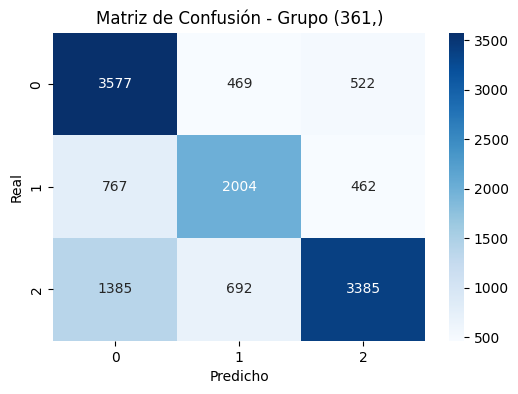


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 5462, np.int64(1): 4568, np.int64(2): 3233})
🔵 Predichos: Counter({np.int64(1): 5729, np.int64(3): 4369, np.int64(2): 3165})

🔍 Primeras 5 predicciones con probabilidades:
[[6.1643922e-01 9.3729585e-02 2.8983119e-01]
 [2.2536913e-01 1.4077479e-03 7.7322322e-01]
 [1.7670233e-02 4.1010004e-01 5.7222968e-01]
 [8.0938029e-05 4.6474591e-07 9.9991858e-01]
 [9.5218176e-01 3.2197304e-02 1.5620954e-02]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(361,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(361,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 133957
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7600
────────────────────────────────────────────

🟨 Procesando grupo: (386,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(386,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.25054 | val_0_accuracy: 0.31904 |  0:00:03s
epoch 1  | loss: 3.0702  | val_0_accuracy: 0.32505 |  0:00:06s
epoch 2  | loss: 2.96992 | val_0_accuracy: 0.33487 |  0:00:10s
epoch 3  | loss: 2.86185 | val_0_accuracy: 0.33449 |  0:00:13s
epoch 4  | loss: 2.7939  | val_0_accuracy: 0.33068 |  0:00:16s
epoch 5  | loss: 2.68437 | val_0_accuracy: 0.3457  |  0:00:20s
epoch 6  | loss: 2.65444 | val_0_accuracy: 0.34755 |  0:00:23s
epoch 7  | loss: 2.54602 | val_0_accuracy: 0.34685 |  0:00:27s
epoch 8  | loss: 2.48797 | val_0_accuracy: 0.33272 |  0:00:30s
epoch 9  | loss: 2.44302 | val_0_accuracy: 0.34816 |  0:00:33s
epoch 10 | loss: 2.37701 | val_0_accuracy: 0.35649 |  0:00:37s
epoch 11 | loss: 2.25617 | val_0_accuracy: 0.34905 |  0:00:40s
epoch 12 | loss: 2.20797 | val_0_accuracy: 0.37151 |  0:00:43s
epoch 13 | loss: 2.12664 | val_0_accuracy: 0.3598  |  0:00:47s
epoch 14 | loss: 2.08161 | val_0_accuracy: 0.36673 |  0:00:50s
epoch 15 | loss: 2.04016 | val_0_accuracy: 0.35668 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.71319

✅ Precisión en test para grupo (386,): 0.77539

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.66      0.84      0.73      3660
           2       0.72      0.72      0.72      4628
           3       0.75      0.59      0.66      4498

    accuracy                           0.71     12786
   macro avg       0.71      0.71      0.70     12786
weighted avg       0.71      0.71      0.70     12786


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.80      0.81      0.81 1386.1243888911956
           2       0.76      0.82      0.79 1154.5555304796533
           3       0.75      0.64      0.69 756.6653937250969

    accuracy                           0.78 3297.345313095946
   macro avg       0.77      0.76      0.76 3297.345313095946
weighted avg       0.77      0.78      0.77 3297.345313095946



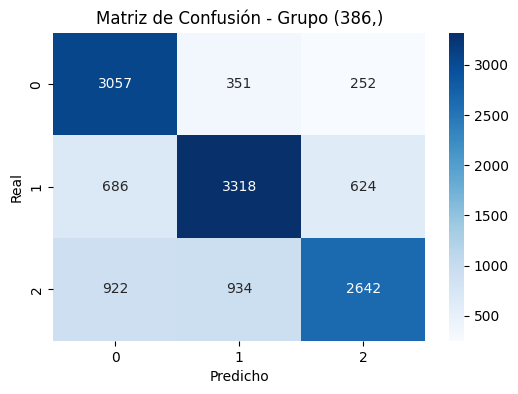


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 4628, np.int64(3): 4498, np.int64(1): 3660})
🔵 Predichos: Counter({np.int64(1): 4665, np.int64(2): 4603, np.int64(3): 3518})

🔍 Primeras 5 predicciones con probabilidades:
[[0.49682623 0.2287484  0.27442533]
 [0.22581482 0.59678996 0.17739522]
 [0.7390459  0.25958446 0.0013696 ]
 [0.48048627 0.1635633  0.35595036]
 [0.776766   0.1231783  0.10005574]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(386,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(386,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 129147
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7754
────────────────────────────────────────────

🟨 Procesando grupo: (399,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(399,).pkl
📊 Clases únicas en y_train: Counter({np.int64(0): 42908, np.int64(1): 362

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.38733 | val_0_accuracy: 0.3307  |  0:00:03s
epoch 1  | loss: 2.9532  | val_0_accuracy: 0.32193 |  0:00:07s
epoch 2  | loss: 2.96661 | val_0_accuracy: 0.32585 |  0:00:11s
epoch 3  | loss: 2.96606 | val_0_accuracy: 0.32806 |  0:00:14s
epoch 4  | loss: 2.81519 | val_0_accuracy: 0.32789 |  0:00:18s
epoch 5  | loss: 2.7541  | val_0_accuracy: 0.3231  |  0:00:21s
epoch 6  | loss: 2.68563 | val_0_accuracy: 0.30989 |  0:00:25s
epoch 7  | loss: 2.55865 | val_0_accuracy: 0.34067 |  0:00:29s
epoch 8  | loss: 2.41561 | val_0_accuracy: 0.34506 |  0:00:33s
epoch 9  | loss: 2.33085 | val_0_accuracy: 0.35004 |  0:00:36s
epoch 10 | loss: 2.27193 | val_0_accuracy: 0.33967 |  0:00:40s
epoch 11 | loss: 2.2053  | val_0_accuracy: 0.34894 |  0:00:44s
epoch 12 | loss: 2.09287 | val_0_accuracy: 0.37561 |  0:00:47s
epoch 13 | loss: 2.06095 | val_0_accuracy: 0.36992 |  0:00:51s
epoch 14 | loss: 1.96438 | val_0_accuracy: 0.37534 |  0:00:55s
epoch 15 | loss: 1.90625 | val_0_accuracy: 0.38207 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.72885

✅ Precisión en test para grupo (399,): 0.73189

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6069
           1       0.74      0.74      0.74      5134
           3       0.61      0.67      0.64      3516

    accuracy                           0.74     14719
   macro avg       0.72      0.73      0.73     14719
weighted avg       0.74      0.74      0.74     14719


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.71      0.74      0.72 808.3172057525986
           1       0.70      0.72      0.71 951.1025183653372
           3       0.78      0.74      0.76 1100.095063605058

    accuracy                           0.73 2859.514787722994
   macro avg       0.73      0.73      0.73 2859.514787722994
weighted avg       0.73      0.73      0.73 2859.514787722994



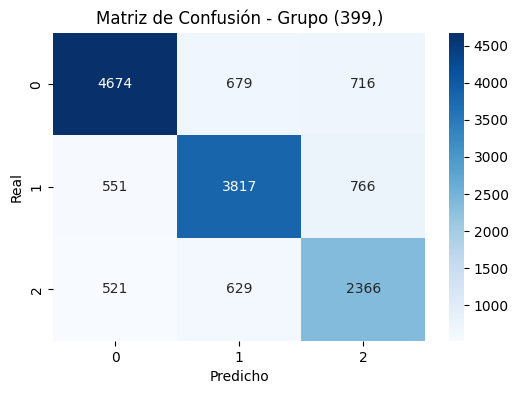


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 6069, np.int64(1): 5134, np.int64(3): 3516})
🔵 Predichos: Counter({np.int64(0): 5746, np.int64(1): 5125, np.int64(3): 3848})

🔍 Primeras 5 predicciones con probabilidades:
[[0.33949336 0.21506616 0.44544047]
 [0.4040707  0.50662124 0.08930805]
 [0.8721274  0.03264977 0.09522282]
 [0.1636317  0.74436164 0.09200668]
 [0.00333336 0.93929344 0.05737316]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(399,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(399,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 148667
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(3)]
🎯 Accuracy test: 0.7319
────────────────────────────────────────────

🟨 Procesando grupo: (456,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(456,).pkl
📊 Clases únicas en y_train: Counter({np.int64(0): 35952, np.int64(1): 328

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.06599 | val_0_accuracy: 0.33402 |  0:00:03s
epoch 1  | loss: 2.86475 | val_0_accuracy: 0.32297 |  0:00:06s
epoch 2  | loss: 2.84139 | val_0_accuracy: 0.33283 |  0:00:09s
epoch 3  | loss: 2.82102 | val_0_accuracy: 0.34941 |  0:00:12s
epoch 4  | loss: 2.8207  | val_0_accuracy: 0.33252 |  0:00:15s
epoch 5  | loss: 2.80408 | val_0_accuracy: 0.34207 |  0:00:18s
epoch 6  | loss: 2.6762  | val_0_accuracy: 0.34925 |  0:00:21s
epoch 7  | loss: 2.57281 | val_0_accuracy: 0.35568 |  0:00:25s
epoch 8  | loss: 2.53122 | val_0_accuracy: 0.34448 |  0:00:28s
epoch 9  | loss: 2.39138 | val_0_accuracy: 0.36164 |  0:00:31s
epoch 10 | loss: 2.30746 | val_0_accuracy: 0.35963 |  0:00:34s
epoch 11 | loss: 2.27039 | val_0_accuracy: 0.36527 |  0:00:37s
epoch 12 | loss: 2.20601 | val_0_accuracy: 0.37163 |  0:00:40s
epoch 13 | loss: 2.08177 | val_0_accuracy: 0.38335 |  0:00:44s
epoch 14 | loss: 1.94982 | val_0_accuracy: 0.40801 |  0:00:47s
epoch 15 | loss: 1.91108 | val_0_accuracy: 0.41164 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.77350

✅ Precisión en test para grupo (456,): 0.78418

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.80      0.86      0.82      5085
           1       0.87      0.76      0.81      4649
           3       0.66      0.70      0.68      2748

    accuracy                           0.79     12482
   macro avg       0.77      0.77      0.77     12482
weighted avg       0.79      0.79      0.79     12482


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.78      0.85      0.81 1218.5801698678924
           1       0.76      0.76      0.76 648.4293666380916
           3       0.80      0.72      0.76 929.4844241318044

    accuracy                           0.78 2796.4939606377884
   macro avg       0.78      0.78      0.78 2796.4939606377884
weighted avg       0.78      0.78      0.78 2796.4939606377884



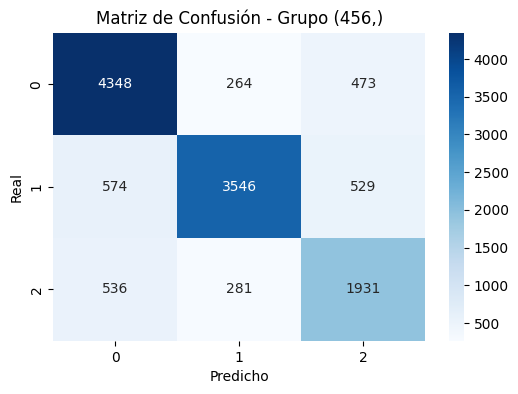


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5085, np.int64(1): 4649, np.int64(3): 2748})
🔵 Predichos: Counter({np.int64(0): 5458, np.int64(1): 4091, np.int64(3): 2933})

🔍 Primeras 5 predicciones con probabilidades:
[[1.7577738e-06 1.0307344e-01 8.9692485e-01]
 [5.6314385e-03 9.6123773e-01 3.3130832e-02]
 [4.4653565e-01 1.5224934e-01 4.0121502e-01]
 [7.9458607e-03 7.3835462e-01 2.5369954e-01]
 [2.5184989e-01 7.4344411e-02 6.7380565e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(456,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(456,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 126073
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(3)]
🎯 Accuracy test: 0.7842
────────────────────────────────────────────

🟨 Procesando grupo: (480,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(480,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.99886 | val_0_accuracy: 0.24519 |  0:00:02s
epoch 1  | loss: 6.49228 | val_0_accuracy: 0.27216 |  0:00:05s
epoch 2  | loss: 5.94175 | val_0_accuracy: 0.27804 |  0:00:08s
epoch 3  | loss: 5.26387 | val_0_accuracy: 0.28116 |  0:00:11s
epoch 4  | loss: 4.61816 | val_0_accuracy: 0.27234 |  0:00:14s
epoch 5  | loss: 4.07974 | val_0_accuracy: 0.27813 |  0:00:17s
epoch 6  | loss: 3.84087 | val_0_accuracy: 0.25218 |  0:00:19s
epoch 7  | loss: 3.58683 | val_0_accuracy: 0.25027 |  0:00:22s
epoch 8  | loss: 3.4043  | val_0_accuracy: 0.27114 |  0:00:25s
epoch 9  | loss: 3.26025 | val_0_accuracy: 0.26727 |  0:00:28s
epoch 10 | loss: 3.2404  | val_0_accuracy: 0.25739 |  0:00:30s
epoch 11 | loss: 3.14855 | val_0_accuracy: 0.27924 |  0:00:33s
epoch 12 | loss: 3.10767 | val_0_accuracy: 0.25863 |  0:00:36s
epoch 13 | loss: 2.99552 | val_0_accuracy: 0.26295 |  0:00:39s
epoch 14 | loss: 2.8949  | val_0_accuracy: 0.27884 |  0:00:42s
epoch 15 | loss: 2.78106 | val_0_accuracy: 0.28934 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.65940

✅ Precisión en test para grupo (480,): 0.71659

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      5126
           1       0.66      0.66      0.66      2589
           2       0.58      0.63      0.60      1573
           3       0.57      0.61      0.59      1779

    accuracy                           0.68     11067
   macro avg       0.65      0.66      0.65     11067
weighted avg       0.69      0.68      0.68     11067


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.67      0.75      0.71 704.3057789429342
           1       0.68      0.70      0.69 534.8971064699974
           2       0.75      0.68      0.71 622.044530795582
           3       0.78      0.73      0.75 694.546754368746

    accuracy                           0.72 2555.7941705772596
   macro avg       0.72      0.71      

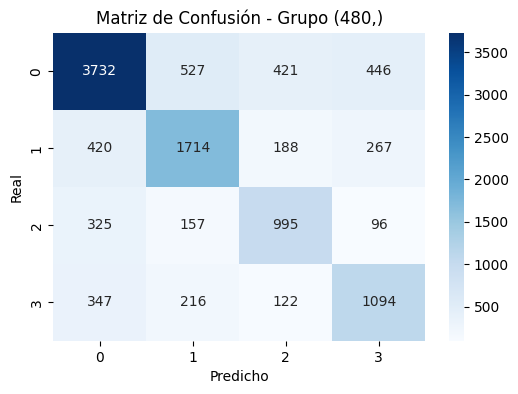


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5126, np.int64(1): 2589, np.int64(3): 1779, np.int64(2): 1573})
🔵 Predichos: Counter({np.int64(0): 4824, np.int64(1): 2614, np.int64(3): 1903, np.int64(2): 1726})

🔍 Primeras 5 predicciones con probabilidades:
[[0.5873978  0.1798414  0.03455558 0.1982052 ]
 [0.4056765  0.27228874 0.10418741 0.21784729]
 [0.2860088  0.00901602 0.45636815 0.24860702]
 [0.02936105 0.00424163 0.09181365 0.8745837 ]
 [0.1186522  0.74355614 0.01506643 0.12272525]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(480,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(480,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 111781
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7166
────────────────────────────────────────────

🟨 Procesando grupo: (516,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.62034 | val_0_accuracy: 0.25602 |  0:00:02s
epoch 1  | loss: 6.07546 | val_0_accuracy: 0.24672 |  0:00:05s
epoch 2  | loss: 5.48458 | val_0_accuracy: 0.27964 |  0:00:08s
epoch 3  | loss: 4.97771 | val_0_accuracy: 0.27266 |  0:00:11s
epoch 4  | loss: 4.49157 | val_0_accuracy: 0.26252 |  0:00:14s
epoch 5  | loss: 4.06947 | val_0_accuracy: 0.28973 |  0:00:17s
epoch 6  | loss: 3.76881 | val_0_accuracy: 0.27187 |  0:00:19s
epoch 7  | loss: 3.66451 | val_0_accuracy: 0.25813 |  0:00:22s
epoch 8  | loss: 3.54898 | val_0_accuracy: 0.27226 |  0:00:25s
epoch 9  | loss: 3.48576 | val_0_accuracy: 0.26682 |  0:00:28s
epoch 10 | loss: 3.48291 | val_0_accuracy: 0.2645  |  0:00:30s
epoch 11 | loss: 3.40402 | val_0_accuracy: 0.27529 |  0:00:33s
epoch 12 | loss: 3.34822 | val_0_accuracy: 0.28425 |  0:00:36s
epoch 13 | loss: 3.35625 | val_0_accuracy: 0.26871 |  0:00:39s
epoch 14 | loss: 3.33697 | val_0_accuracy: 0.27556 |  0:00:42s
epoch 15 | loss: 3.30336 | val_0_accuracy: 0.28126 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.63055

✅ Precisión en test para grupo (516,): 0.67521

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      5735
           1       0.51      0.58      0.54      1602
           2       0.41      0.67      0.51       872
           3       0.64      0.54      0.59      3013

    accuracy                           0.65     11222
   macro avg       0.58      0.63      0.60     11222
weighted avg       0.67      0.65      0.66     11222


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.58      0.72      0.64 912.2451932323202
           1       0.74      0.62      0.67 840.9713508308779
           2       0.77      0.73      0.75 1074.0040568267589
           3       0.62      0.60      0.61 739.7055902065936

    accuracy                           0.68 3566.92619109655
   macro avg       0.68      0.67     

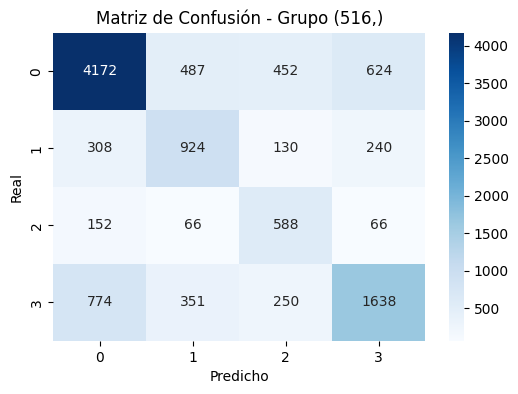


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5735, np.int64(3): 3013, np.int64(1): 1602, np.int64(2): 872})
🔵 Predichos: Counter({np.int64(0): 5406, np.int64(3): 2568, np.int64(1): 1828, np.int64(2): 1420})

🔍 Primeras 5 predicciones con probabilidades:
[[6.0038191e-01 1.8297787e-01 1.2756339e-01 8.9076824e-02]
 [9.9712616e-01 3.7065893e-04 1.7072911e-05 2.4860324e-03]
 [5.1548761e-01 1.2169224e-02 2.8581709e-01 1.8652609e-01]
 [4.3758273e-02 7.1458554e-01 2.3906006e-01 2.5962235e-03]
 [9.7051233e-01 2.7372362e-03 9.7300153e-04 2.5777414e-02]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(516,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(516,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 113347
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.6752
────────────────────────────────────────────

🟨 Procesando grupo: (540,)
✅ Sc

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.1487  | val_0_accuracy: 0.33429 |  0:00:03s
epoch 1  | loss: 2.98379 | val_0_accuracy: 0.33425 |  0:00:06s
epoch 2  | loss: 2.88069 | val_0_accuracy: 0.34334 |  0:00:09s
epoch 3  | loss: 2.90583 | val_0_accuracy: 0.32919 |  0:00:13s
epoch 4  | loss: 2.84484 | val_0_accuracy: 0.33905 |  0:00:16s
epoch 5  | loss: 2.74912 | val_0_accuracy: 0.33364 |  0:00:19s
epoch 6  | loss: 2.63984 | val_0_accuracy: 0.33832 |  0:00:23s
epoch 7  | loss: 2.57878 | val_0_accuracy: 0.34411 |  0:00:26s
epoch 8  | loss: 2.49857 | val_0_accuracy: 0.3532  |  0:00:29s
epoch 9  | loss: 2.47345 | val_0_accuracy: 0.36045 |  0:00:32s
epoch 10 | loss: 2.40009 | val_0_accuracy: 0.34921 |  0:00:36s
epoch 11 | loss: 2.34635 | val_0_accuracy: 0.35826 |  0:00:39s
epoch 12 | loss: 2.28976 | val_0_accuracy: 0.38158 |  0:00:42s
epoch 13 | loss: 2.20643 | val_0_accuracy: 0.37912 |  0:00:46s
epoch 14 | loss: 2.05964 | val_0_accuracy: 0.38691 |  0:00:49s
epoch 15 | loss: 1.9785  | val_0_accuracy: 0.38848 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.75523

✅ Precisión en test para grupo (540,): 0.79958

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      5432
           1       0.83      0.75      0.79      4820
           2       0.62      0.70      0.66      2592

    accuracy                           0.77     12844
   macro avg       0.75      0.76      0.75     12844
weighted avg       0.77      0.77      0.77     12844


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.82      0.85      0.84 948.0930739087394
           1       0.78      0.80      0.79 596.3208555005526
           2       0.78      0.73      0.75 684.0828432121608

    accuracy                           0.80 2228.4967726214527
   macro avg       0.80      0.79      0.79 2228.4967726214527
weighted avg       0.80      0.80      0.80 2228.4967726214527



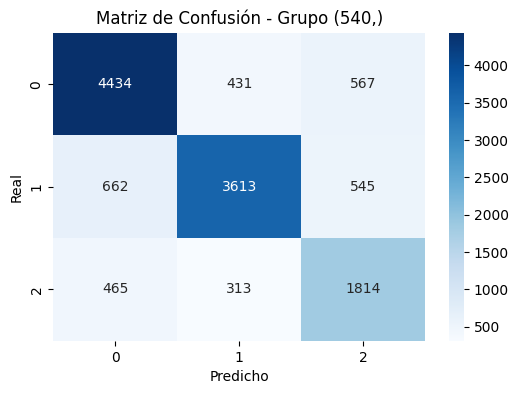


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5432, np.int64(1): 4820, np.int64(2): 2592})
🔵 Predichos: Counter({np.int64(0): 5561, np.int64(1): 4357, np.int64(2): 2926})

🔍 Primeras 5 predicciones con probabilidades:
[[6.4380944e-01 3.0562854e-01 5.0561983e-02]
 [3.5587706e-02 9.6366018e-01 7.5213396e-04]
 [5.3710163e-01 2.9549834e-01 1.6740000e-01]
 [2.0767271e-04 9.3383688e-01 6.5955438e-02]
 [9.8471731e-01 6.2403851e-05 1.5220258e-02]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(540,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(540,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 129732
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2)]
🎯 Accuracy test: 0.7996
────────────────────────────────────────────

🟨 Procesando grupo: (598,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(598,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.19883 | val_0_accuracy: 0.3614  |  0:00:01s
epoch 1  | loss: 3.02545 | val_0_accuracy: 0.33137 |  0:00:02s
epoch 2  | loss: 2.9962  | val_0_accuracy: 0.31515 |  0:00:04s
epoch 3  | loss: 2.98528 | val_0_accuracy: 0.31313 |  0:00:06s
epoch 4  | loss: 2.95483 | val_0_accuracy: 0.35131 |  0:00:07s
epoch 5  | loss: 2.82674 | val_0_accuracy: 0.35589 |  0:00:09s
epoch 6  | loss: 2.78383 | val_0_accuracy: 0.34448 |  0:00:10s
epoch 7  | loss: 2.81729 | val_0_accuracy: 0.31864 |  0:00:12s
epoch 8  | loss: 2.73376 | val_0_accuracy: 0.34433 |  0:00:13s
epoch 9  | loss: 2.74793 | val_0_accuracy: 0.35255 |  0:00:15s
epoch 10 | loss: 2.68953 | val_0_accuracy: 0.31872 |  0:00:16s
epoch 11 | loss: 2.66865 | val_0_accuracy: 0.34681 |  0:00:18s
epoch 12 | loss: 2.59733 | val_0_accuracy: 0.36738 |  0:00:19s
epoch 13 | loss: 2.61227 | val_0_accuracy: 0.33276 |  0:00:21s
epoch 14 | loss: 2.56818 | val_0_accuracy: 0.34503 |  0:00:22s
epoch 15 | loss: 2.58561 | val_0_accuracy: 0.34448 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.70953

✅ Precisión en test para grupo (598,): 0.79610

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2603
           1       0.74      0.70      0.72      2486
           2       0.64      0.62      0.63      1258

    accuracy                           0.73      6347
   macro avg       0.71      0.71      0.71      6347
weighted avg       0.73      0.73      0.73      6347


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.83      0.84      0.84 752.82251930171
           1       0.74      0.76      0.75 480.84279138699355
           2       0.80      0.76      0.78 479.1448132856544

    accuracy                           0.80 1712.810123974358
   macro avg       0.79      0.79      0.79 1712.810123974358
weighted avg       0.80      0.80      0.80 1712.810123974358



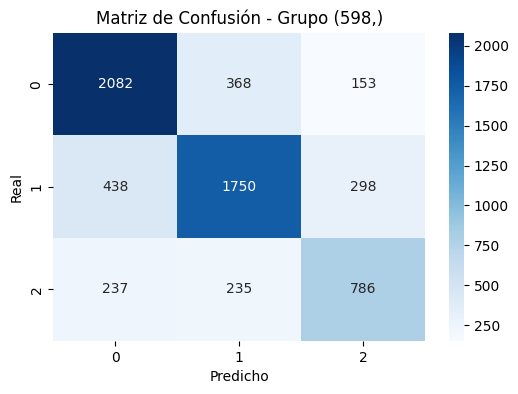


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 2603, np.int64(1): 2486, np.int64(2): 1258})
🔵 Predichos: Counter({np.int64(0): 2757, np.int64(1): 2353, np.int64(2): 1237})

🔍 Primeras 5 predicciones con probabilidades:
[[0.77491975 0.01554427 0.20953594]
 [0.45322567 0.01906727 0.52770704]
 [0.7264678  0.1674656  0.10606654]
 [0.5689062  0.23081608 0.20027779]
 [0.0620724  0.68449587 0.25343168]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(598,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(598,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 64110
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2)]
🎯 Accuracy test: 0.7961
────────────────────────────────────────────

🟨 Procesando grupo: (599,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(599,).pkl
📊 Clases únicas en y_train: Counter({np.int64(0): 21258, np.int64(1): 9391

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.20364 | val_0_accuracy: 0.36856 |  0:00:01s
epoch 1  | loss: 2.97749 | val_0_accuracy: 0.33193 |  0:00:02s
epoch 2  | loss: 2.92805 | val_0_accuracy: 0.28852 |  0:00:03s
epoch 3  | loss: 2.8294  | val_0_accuracy: 0.29317 |  0:00:05s
epoch 4  | loss: 2.82304 | val_0_accuracy: 0.3172  |  0:00:06s
epoch 5  | loss: 2.77692 | val_0_accuracy: 0.31103 |  0:00:07s
epoch 6  | loss: 2.72418 | val_0_accuracy: 0.32666 |  0:00:09s
epoch 7  | loss: 2.6605  | val_0_accuracy: 0.35257 |  0:00:10s
epoch 8  | loss: 2.60005 | val_0_accuracy: 0.3423  |  0:00:11s
epoch 9  | loss: 2.60542 | val_0_accuracy: 0.32943 |  0:00:13s
epoch 10 | loss: 2.58595 | val_0_accuracy: 0.34051 |  0:00:14s
epoch 11 | loss: 2.54047 | val_0_accuracy: 0.33729 |  0:00:15s
epoch 12 | loss: 2.49701 | val_0_accuracy: 0.33506 |  0:00:17s
epoch 13 | loss: 2.51886 | val_0_accuracy: 0.34015 |  0:00:18s
epoch 14 | loss: 2.48139 | val_0_accuracy: 0.34551 |  0:00:19s
epoch 15 | loss: 2.47025 | val_0_accuracy: 0.36829 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.65502

✅ Precisión en test para grupo (599,): 0.71986

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      3007
           1       0.72      0.53      0.61      1328
           3       0.61      0.58      0.60      1180

    accuracy                           0.72      5515
   macro avg       0.69      0.66      0.67      5515
weighted avg       0.71      0.72      0.71      5515


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.70      0.83      0.76 740.6252802908288
           1       0.62      0.61      0.61 303.13784264125127
           3       0.82      0.65      0.72 680.6149138268814

    accuracy                           0.72 1724.3780367589616
   macro avg       0.71      0.70      0.70 1724.3780367589616
weighted avg       0.73      0.72      0.72 1724.3780367589616



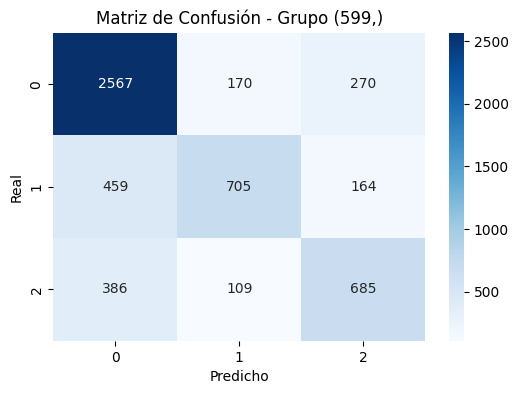


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 3007, np.int64(1): 1328, np.int64(3): 1180})
🔵 Predichos: Counter({np.int64(0): 3412, np.int64(3): 1119, np.int64(1): 984})

🔍 Primeras 5 predicciones con probabilidades:
[[0.99482864 0.00152439 0.00364698]
 [0.12785508 0.07243611 0.79970884]
 [0.0454209  0.8929516  0.06162753]
 [0.430988   0.44556898 0.12344305]
 [0.09319557 0.00337625 0.9034281 ]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(599,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(599,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 55699
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(3)]
🎯 Accuracy test: 0.7199
────────────────────────────────────────────

🟨 Procesando grupo: (691,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(691,).pkl
📊 Clases únicas en y_train: Counter({np.int64(1): 43702, np.int64(0): 39124

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.16206 | val_0_accuracy: 0.28401 |  0:00:04s
epoch 1  | loss: 5.5158  | val_0_accuracy: 0.29463 |  0:00:08s
epoch 2  | loss: 4.78115 | val_0_accuracy: 0.27273 |  0:00:12s
epoch 3  | loss: 3.97161 | val_0_accuracy: 0.27823 |  0:00:16s
epoch 4  | loss: 3.59825 | val_0_accuracy: 0.29132 |  0:00:21s
epoch 5  | loss: 3.42682 | val_0_accuracy: 0.27041 |  0:00:25s
epoch 6  | loss: 3.2755  | val_0_accuracy: 0.28458 |  0:00:29s
epoch 7  | loss: 3.13076 | val_0_accuracy: 0.29533 |  0:00:33s
epoch 8  | loss: 3.09958 | val_0_accuracy: 0.2943  |  0:00:37s
epoch 9  | loss: 2.98338 | val_0_accuracy: 0.30926 |  0:00:41s
epoch 10 | loss: 2.81757 | val_0_accuracy: 0.31543 |  0:00:45s
epoch 11 | loss: 2.73729 | val_0_accuracy: 0.32015 |  0:00:50s
epoch 12 | loss: 2.64361 | val_0_accuracy: 0.33384 |  0:00:54s
epoch 13 | loss: 2.57218 | val_0_accuracy: 0.33153 |  0:00:58s
epoch 14 | loss: 2.44292 | val_0_accuracy: 0.34627 |  0:01:02s
epoch 15 | loss: 2.41506 | val_0_accuracy: 0.34314 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.66557

✅ Precisión en test para grupo (691,): 0.73262

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.74      0.60      0.66      5534
           1       0.79      0.75      0.77      6181
           2       0.46      0.64      0.53      2495
           3       0.58      0.67      0.62      2158

    accuracy                           0.67     16368
   macro avg       0.64      0.67      0.65     16368
weighted avg       0.69      0.67      0.68     16368


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.70      0.70      0.70 996.8445383798995
           1       0.74      0.75      0.74 1183.350937556842
           2       0.71      0.75      0.73 1131.687668567538
           3       0.78      0.73      0.75 899.902601994738

    accuracy                           0.73 4211.7857464990175
   macro avg       0.74      0.73     

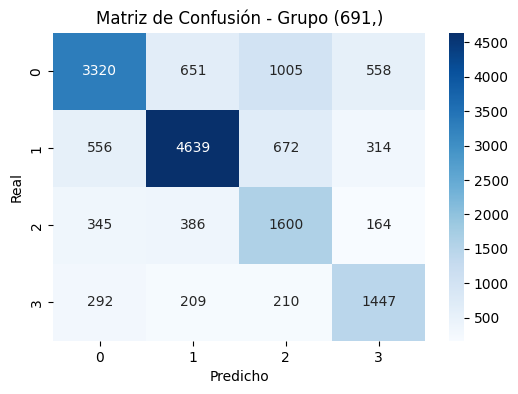


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 6181, np.int64(0): 5534, np.int64(2): 2495, np.int64(3): 2158})
🔵 Predichos: Counter({np.int64(1): 5885, np.int64(0): 4513, np.int64(2): 3487, np.int64(3): 2483})

🔍 Primeras 5 predicciones con probabilidades:
[[2.1255437e-01 7.8166163e-01 5.7585235e-03 2.5577574e-05]
 [9.6228272e-02 3.7761578e-01 4.8221067e-01 4.3945320e-02]
 [5.5809007e-03 6.0952330e-01 3.7323052e-01 1.1665261e-02]
 [2.9527646e-01 2.0327970e-01 2.3089169e-01 2.7055210e-01]
 [4.3691576e-01 2.5428964e-02 3.7794459e-01 1.5971065e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(691,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(691,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 165330
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7326
────────────────────────────────────────────

🟨 Procesando grupo: (716,)
✅ S

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.49307 | val_0_accuracy: 0.34352 |  0:00:01s
epoch 1  | loss: 3.1965  | val_0_accuracy: 0.3403  |  0:00:03s
epoch 2  | loss: 3.00544 | val_0_accuracy: 0.34308 |  0:00:04s
epoch 3  | loss: 2.92014 | val_0_accuracy: 0.36151 |  0:00:06s
epoch 4  | loss: 2.92751 | val_0_accuracy: 0.34974 |  0:00:08s
epoch 5  | loss: 2.99769 | val_0_accuracy: 0.36385 |  0:00:09s
epoch 6  | loss: 2.83197 | val_0_accuracy: 0.33431 |  0:00:11s
epoch 7  | loss: 2.76482 | val_0_accuracy: 0.34623 |  0:00:13s
epoch 8  | loss: 2.74062 | val_0_accuracy: 0.35873 |  0:00:14s
epoch 9  | loss: 2.68461 | val_0_accuracy: 0.35478 |  0:00:16s
epoch 10 | loss: 2.66607 | val_0_accuracy: 0.34498 |  0:00:18s
epoch 11 | loss: 2.66984 | val_0_accuracy: 0.32319 |  0:00:19s
epoch 12 | loss: 2.60684 | val_0_accuracy: 0.3425  |  0:00:21s
epoch 13 | loss: 2.53709 | val_0_accuracy: 0.3425  |  0:00:22s
epoch 14 | loss: 2.50061 | val_0_accuracy: 0.36202 |  0:00:24s
epoch 15 | loss: 2.42032 | val_0_accuracy: 0.3561  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.67206

✅ Precisión en test para grupo (716,): 0.73765

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.79      0.57      0.66      1897
           2       0.67      0.58      0.62      1402
           3       0.72      0.87      0.79      3438

    accuracy                           0.73      6737
   macro avg       0.73      0.67      0.69      6737
weighted avg       0.73      0.73      0.72      6737


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.83      0.66      0.73 604.9607567172462
           2       0.79      0.68      0.73 604.8361204857489
           3       0.66      0.86      0.74 686.5154483949011

    accuracy                           0.74 1896.3123255978962
   macro avg       0.76      0.73      0.74 1896.3123255978962
weighted avg       0.75      0.74      0.74 1896.3123255978962



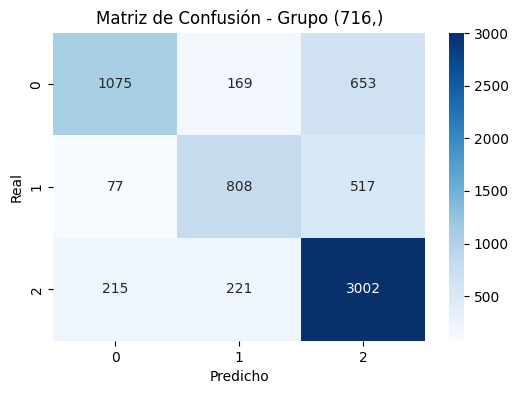


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 3438, np.int64(1): 1897, np.int64(2): 1402})
🔵 Predichos: Counter({np.int64(3): 4172, np.int64(1): 1367, np.int64(2): 1198})

🔍 Primeras 5 predicciones con probabilidades:
[[3.6376246e-08 9.9996459e-01 3.5319248e-05]
 [9.6023018e-03 3.6653987e-04 9.9003112e-01]
 [3.3984953e-01 4.9985763e-02 6.1016476e-01]
 [2.1308009e-01 4.7600433e-01 3.1091559e-01]
 [1.6310021e-01 2.0805016e-01 6.2884963e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(716,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(716,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 68041
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7377
────────────────────────────────────────────

🟨 Procesando grupo: (728,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(728,).pkl
📊 Clases únicas en y_train: C

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.73546 | val_0_accuracy: 0.34407 |  0:00:01s
epoch 1  | loss: 3.37606 | val_0_accuracy: 0.33204 |  0:00:03s
epoch 2  | loss: 3.25932 | val_0_accuracy: 0.31521 |  0:00:05s
epoch 3  | loss: 3.16863 | val_0_accuracy: 0.2956  |  0:00:07s
epoch 4  | loss: 3.10986 | val_0_accuracy: 0.31027 |  0:00:09s
epoch 5  | loss: 3.03832 | val_0_accuracy: 0.29483 |  0:00:10s
epoch 6  | loss: 3.04129 | val_0_accuracy: 0.28809 |  0:00:12s
epoch 7  | loss: 2.9198  | val_0_accuracy: 0.30582 |  0:00:14s
epoch 8  | loss: 2.8271  | val_0_accuracy: 0.31729 |  0:00:16s
epoch 9  | loss: 2.82834 | val_0_accuracy: 0.30728 |  0:00:17s
epoch 10 | loss: 2.76714 | val_0_accuracy: 0.29956 |  0:00:19s
epoch 11 | loss: 2.75249 | val_0_accuracy: 0.32355 |  0:00:21s
epoch 12 | loss: 2.80003 | val_0_accuracy: 0.31597 |  0:00:23s
epoch 13 | loss: 2.72257 | val_0_accuracy: 0.31729 |  0:00:25s
epoch 14 | loss: 2.67348 | val_0_accuracy: 0.33343 |  0:00:26s
epoch 15 | loss: 2.69929 | val_0_accuracy: 0.32063 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.64686

✅ Precisión en test para grupo (728,): 0.69372

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.69      0.61      0.65      2590
           2       0.53      0.65      0.58      1541
           3       0.69      0.68      0.69      2953

    accuracy                           0.65      7084
   macro avg       0.64      0.65      0.64      7084
weighted avg       0.66      0.65      0.65      7084


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.61      0.69      0.65 471.10910195500634
           2       0.75      0.65      0.70 657.663063728638
           3       0.71      0.75      0.73 497.7229301498908

    accuracy                           0.69 1626.495095833535
   macro avg       0.69      0.70      0.69 1626.495095833535
weighted avg       0.70      0.69      0.69 1626.495095833535



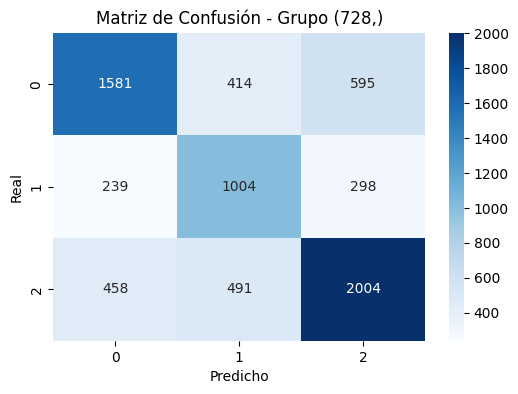


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 2953, np.int64(1): 2590, np.int64(2): 1541})
🔵 Predichos: Counter({np.int64(3): 2897, np.int64(1): 2278, np.int64(2): 1909})

🔍 Primeras 5 predicciones con probabilidades:
[[1.37311280e-01 8.62572193e-01 1.16485731e-04]
 [3.82780939e-01 1.49291769e-01 4.67927277e-01]
 [5.36133200e-02 9.32378948e-01 1.40077630e-02]
 [8.63050938e-01 1.25360116e-01 1.15888976e-02]
 [1.15902305e-01 3.01909983e-01 5.82187653e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(728,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(728,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 71547
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.6937
────────────────────────────────────────────

🟨 Procesando grupo: (753,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(753,).pkl
📊 Clases única

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.58889 | val_0_accuracy: 0.25175 |  0:00:03s
epoch 1  | loss: 6.04025 | val_0_accuracy: 0.2286  |  0:00:07s
epoch 2  | loss: 5.29098 | val_0_accuracy: 0.23693 |  0:00:11s
epoch 3  | loss: 4.51953 | val_0_accuracy: 0.22938 |  0:00:15s
epoch 4  | loss: 3.8859  | val_0_accuracy: 0.23642 |  0:00:18s
epoch 5  | loss: 3.67162 | val_0_accuracy: 0.24854 |  0:00:22s
epoch 6  | loss: 3.59532 | val_0_accuracy: 0.24436 |  0:00:26s
epoch 7  | loss: 3.57657 | val_0_accuracy: 0.24864 |  0:00:30s
epoch 8  | loss: 3.52131 | val_0_accuracy: 0.24909 |  0:00:34s
epoch 9  | loss: 3.40536 | val_0_accuracy: 0.24634 |  0:00:38s
epoch 10 | loss: 3.33174 | val_0_accuracy: 0.24575 |  0:00:41s
epoch 11 | loss: 3.22353 | val_0_accuracy: 0.25409 |  0:00:45s
epoch 12 | loss: 3.17427 | val_0_accuracy: 0.24708 |  0:00:49s
epoch 13 | loss: 3.09437 | val_0_accuracy: 0.24345 |  0:00:53s
epoch 14 | loss: 2.89178 | val_0_accuracy: 0.25285 |  0:00:56s
epoch 15 | loss: 2.81879 | val_0_accuracy: 0.26945 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.65095

✅ Precisión en test para grupo (753,): 0.71433

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      4693
           1       0.73      0.77      0.75      6118
           2       0.22      0.76      0.35       606
           3       0.63      0.50      0.56      3776

    accuracy                           0.64     15193
   macro avg       0.58      0.65      0.57     15193
weighted avg       0.68      0.64      0.65     15193


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.63      0.60      0.61 961.772994236527
           1       0.69      0.79      0.74 1471.2588260631478
           2       0.78      0.79      0.79 1660.0726963503405
           3       0.72      0.60      0.65 1074.1717035754968

    accuracy                           0.71 5167.276220225513
   macro avg       0.71      0.69   

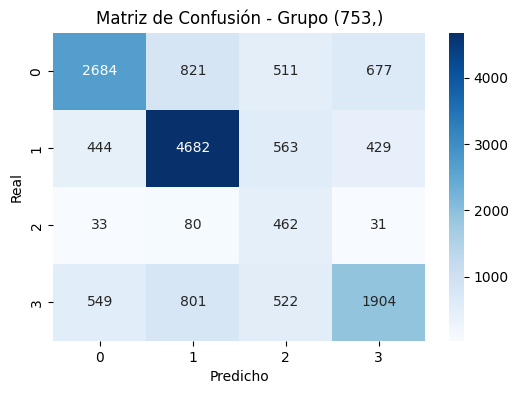


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 6118, np.int64(0): 4693, np.int64(3): 3776, np.int64(2): 606})
🔵 Predichos: Counter({np.int64(1): 6384, np.int64(0): 3710, np.int64(3): 3041, np.int64(2): 2058})

🔍 Primeras 5 predicciones con probabilidades:
[[0.07300043 0.55164826 0.01689339 0.35845786]
 [0.02375222 0.02191388 0.12502864 0.82930523]
 [0.05059665 0.22489259 0.4847564  0.23975438]
 [0.07191247 0.8674417  0.03625499 0.0243908 ]
 [0.10265037 0.69425845 0.12412233 0.07896882]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(753,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(753,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 153454
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7143
────────────────────────────────────────────

🟨 Procesando grupo: (810,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.51475 | val_0_accuracy: 0.33572 |  0:00:03s
epoch 1  | loss: 3.14748 | val_0_accuracy: 0.32309 |  0:00:07s
epoch 2  | loss: 3.11293 | val_0_accuracy: 0.3192  |  0:00:11s
epoch 3  | loss: 3.05016 | val_0_accuracy: 0.31956 |  0:00:14s
epoch 4  | loss: 2.9613  | val_0_accuracy: 0.31679 |  0:00:18s
epoch 5  | loss: 2.85387 | val_0_accuracy: 0.3311  |  0:00:22s
epoch 6  | loss: 2.85194 | val_0_accuracy: 0.32701 |  0:00:26s
epoch 7  | loss: 2.80907 | val_0_accuracy: 0.32932 |  0:00:29s
epoch 8  | loss: 2.63354 | val_0_accuracy: 0.34509 |  0:00:33s
epoch 9  | loss: 2.43645 | val_0_accuracy: 0.36161 |  0:00:37s
epoch 10 | loss: 2.33846 | val_0_accuracy: 0.3753  |  0:00:41s
epoch 11 | loss: 2.28515 | val_0_accuracy: 0.3933  |  0:00:44s
epoch 12 | loss: 2.24701 | val_0_accuracy: 0.38463 |  0:00:48s
epoch 13 | loss: 2.11397 | val_0_accuracy: 0.40379 |  0:00:52s
epoch 14 | loss: 2.03414 | val_0_accuracy: 0.41642 |  0:00:55s
epoch 15 | loss: 1.94516 | val_0_accuracy: 0.40297 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.76314

✅ Precisión en test para grupo (810,): 0.75764

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      6234
           1       0.61      0.83      0.70      3772
           3       0.85      0.70      0.77      4928

    accuracy                           0.76     14934
   macro avg       0.76      0.76      0.75     14934
weighted avg       0.78      0.76      0.76     14934


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.75      0.71      0.73 678.5661442275971
           1       0.73      0.81      0.77 877.6973498565419
           3       0.82      0.74      0.78 633.4804174905116

    accuracy                           0.76 2189.7439115746506
   macro avg       0.76      0.75      0.76 2189.7439115746506
weighted avg       0.76      0.76      0.76 2189.7439115746506



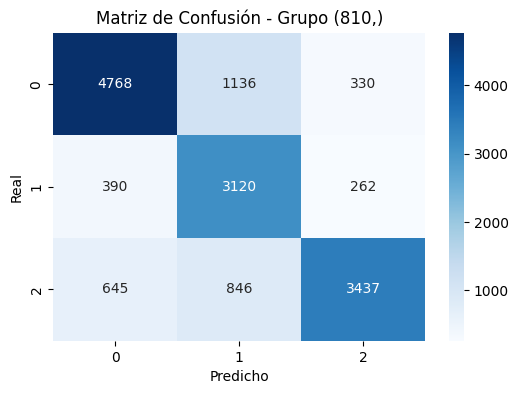


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 6234, np.int64(3): 4928, np.int64(1): 3772})
🔵 Predichos: Counter({np.int64(0): 5803, np.int64(1): 5102, np.int64(3): 4029})

🔍 Primeras 5 predicciones con probabilidades:
[[7.5190198e-01 1.7275761e-01 7.5340465e-02]
 [3.0212302e-04 1.2713184e-03 9.9842668e-01]
 [9.4518560e-01 1.1717679e-02 4.3096840e-02]
 [3.1659657e-01 5.3086120e-01 1.5254222e-01]
 [7.7092683e-01 2.9799031e-02 1.9927414e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(810,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(810,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 150844
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(3)]
🎯 Accuracy test: 0.7576
────────────────────────────────────────────

🟨 Procesando grupo: (834,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(834,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.34091 | val_0_accuracy: 0.34346 |  0:00:02s
epoch 1  | loss: 3.11253 | val_0_accuracy: 0.34024 |  0:00:05s
epoch 2  | loss: 3.04165 | val_0_accuracy: 0.35478 |  0:00:08s
epoch 3  | loss: 3.01858 | val_0_accuracy: 0.36652 |  0:00:10s
epoch 4  | loss: 2.93456 | val_0_accuracy: 0.36191 |  0:00:13s
epoch 5  | loss: 2.89066 | val_0_accuracy: 0.35087 |  0:00:16s
epoch 6  | loss: 2.71804 | val_0_accuracy: 0.35804 |  0:00:18s
epoch 7  | loss: 2.73709 | val_0_accuracy: 0.34993 |  0:00:21s
epoch 8  | loss: 2.7082  | val_0_accuracy: 0.36247 |  0:00:24s
epoch 9  | loss: 2.53818 | val_0_accuracy: 0.36307 |  0:00:27s
epoch 10 | loss: 2.39744 | val_0_accuracy: 0.38763 |  0:00:29s
epoch 11 | loss: 2.34538 | val_0_accuracy: 0.41073 |  0:00:32s
epoch 12 | loss: 2.22759 | val_0_accuracy: 0.40589 |  0:00:35s
epoch 13 | loss: 2.12635 | val_0_accuracy: 0.42392 |  0:00:38s
epoch 14 | loss: 2.0792  | val_0_accuracy: 0.44046 |  0:00:40s
epoch 15 | loss: 2.06228 | val_0_accuracy: 0.41451 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.78075

✅ Precisión en test para grupo (834,): 0.82431

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.84      0.89      0.86      5362
           2       0.80      0.74      0.77      2727
           3       0.75      0.72      0.73      2484

    accuracy                           0.81     10573
   macro avg       0.80      0.78      0.79     10573
weighted avg       0.81      0.81      0.81     10573


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.82      0.88      0.85 851.6753109941565
           2       0.83      0.81      0.82 617.8830760293388
           3       0.82      0.72      0.77 421.894446877605

    accuracy                           0.82 1891.4528339011003
   macro avg       0.82      0.81      0.81 1891.4528339011003
weighted avg       0.82      0.82      0.82 1891.4528339011003



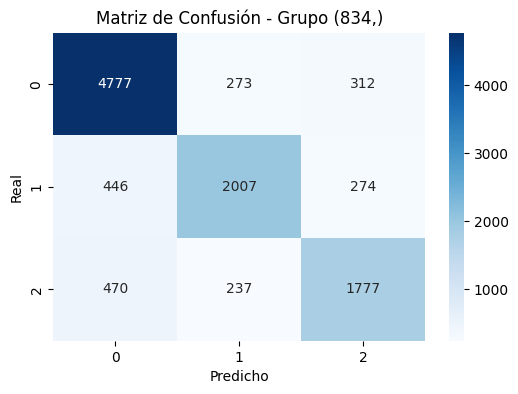


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 5362, np.int64(2): 2727, np.int64(3): 2484})
🔵 Predichos: Counter({np.int64(1): 5693, np.int64(2): 2517, np.int64(3): 2363})

🔍 Primeras 5 predicciones con probabilidades:
[[2.5483108e-05 3.6559216e-04 9.9960893e-01]
 [9.6105558e-01 3.6001984e-02 2.9424273e-03]
 [8.7822199e-01 4.1584127e-02 8.0193773e-02]
 [7.3083368e-04 3.4799750e-03 9.9578911e-01]
 [9.5199656e-01 4.6760477e-02 1.2429957e-03]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(834,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(834,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 106788
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8243
────────────────────────────────────────────

🟨 Procesando grupo: (859,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(859,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.05533 | val_0_accuracy: 0.32658 |  0:00:02s
epoch 1  | loss: 2.90201 | val_0_accuracy: 0.34356 |  0:00:05s
epoch 2  | loss: 2.8613  | val_0_accuracy: 0.33896 |  0:00:08s
epoch 3  | loss: 2.79479 | val_0_accuracy: 0.34788 |  0:00:10s
epoch 4  | loss: 2.71985 | val_0_accuracy: 0.35271 |  0:00:13s
epoch 5  | loss: 2.68836 | val_0_accuracy: 0.36777 |  0:00:16s
epoch 6  | loss: 2.60739 | val_0_accuracy: 0.3446  |  0:00:19s
epoch 7  | loss: 2.5793  | val_0_accuracy: 0.37014 |  0:00:21s
epoch 8  | loss: 2.54473 | val_0_accuracy: 0.36782 |  0:00:24s
epoch 9  | loss: 2.41151 | val_0_accuracy: 0.3867  |  0:00:27s
epoch 10 | loss: 2.35345 | val_0_accuracy: 0.36445 |  0:00:30s
epoch 11 | loss: 2.29128 | val_0_accuracy: 0.39926 |  0:00:33s
epoch 12 | loss: 2.25556 | val_0_accuracy: 0.38752 |  0:00:35s
epoch 13 | loss: 2.19692 | val_0_accuracy: 0.406   |  0:00:38s
epoch 14 | loss: 2.11248 | val_0_accuracy: 0.42366 |  0:00:41s
epoch 15 | loss: 1.97897 | val_0_accuracy: 0.42215 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.75783

✅ Precisión en test para grupo (859,): 0.79495

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.79      0.89      0.84      5053
           2       0.65      0.67      0.66      2017
           3       0.87      0.72      0.79      3753

    accuracy                           0.79     10823
   macro avg       0.77      0.76      0.76     10823
weighted avg       0.79      0.79      0.79     10823


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.79      0.87      0.83 1144.3581533710847
           2       0.76      0.70      0.73 615.7864161117276
           3       0.84      0.76      0.80 687.5323280174996

    accuracy                           0.79 2447.6768975003115
   macro avg       0.80      0.78      0.78 2447.6768975003115
weighted avg       0.80      0.79      0.79 2447.6768975003115



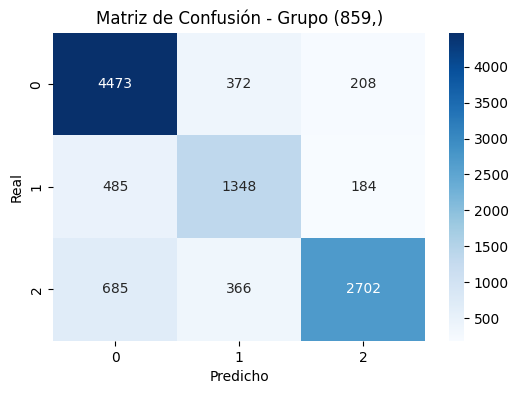


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 5053, np.int64(3): 3753, np.int64(2): 2017})
🔵 Predichos: Counter({np.int64(1): 5643, np.int64(3): 3094, np.int64(2): 2086})

🔍 Primeras 5 predicciones con probabilidades:
[[1.8117155e-01 2.1756589e-01 6.0126257e-01]
 [2.1750981e-01 3.9983520e-01 3.8265502e-01]
 [9.4669944e-01 6.1779283e-03 4.7122668e-02]
 [1.1964576e-02 3.9427466e-04 9.8764116e-01]
 [6.2836739e-03 1.2439586e-03 9.9247241e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(859,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(859,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 109317
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7950
────────────────────────────────────────────

🟨 Procesando grupo: (883,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(883,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.29882 | val_0_accuracy: 0.37462 |  0:00:03s
epoch 1  | loss: 3.02751 | val_0_accuracy: 0.38384 |  0:00:07s
epoch 2  | loss: 2.89593 | val_0_accuracy: 0.38068 |  0:00:11s
epoch 3  | loss: 2.84148 | val_0_accuracy: 0.36353 |  0:00:15s
epoch 4  | loss: 2.82819 | val_0_accuracy: 0.3783  |  0:00:19s
epoch 5  | loss: 2.67861 | val_0_accuracy: 0.38761 |  0:00:22s
epoch 6  | loss: 2.51969 | val_0_accuracy: 0.38458 |  0:00:26s
epoch 7  | loss: 2.48158 | val_0_accuracy: 0.39693 |  0:00:30s
epoch 8  | loss: 2.37993 | val_0_accuracy: 0.40598 |  0:00:34s
epoch 9  | loss: 2.25497 | val_0_accuracy: 0.41385 |  0:00:38s
epoch 10 | loss: 2.09108 | val_0_accuracy: 0.42081 |  0:00:42s
epoch 11 | loss: 1.99142 | val_0_accuracy: 0.42587 |  0:00:45s
epoch 12 | loss: 1.91896 | val_0_accuracy: 0.42032 |  0:00:49s
epoch 13 | loss: 1.87823 | val_0_accuracy: 0.41626 |  0:00:53s
epoch 14 | loss: 1.77551 | val_0_accuracy: 0.44163 |  0:00:57s
epoch 15 | loss: 1.6782  | val_0_accuracy: 0.4465  |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.76144

✅ Precisión en test para grupo (883,): 0.79163

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      6270
           1       0.73      0.78      0.75      5083
           2       0.76      0.73      0.74      3929

    accuracy                           0.76     15282
   macro avg       0.76      0.76      0.76     15282
weighted avg       0.77      0.76      0.76     15282


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.82      0.81      0.81 852.8738293982921
           1       0.77      0.79      0.78 860.7799017655366
           2       0.79      0.77      0.78 593.0134841316631

    accuracy                           0.79 2306.6672152954916
   macro avg       0.79      0.79      0.79 2306.6672152954916
weighted avg       0.79      0.79      0.79 2306.6672152954916



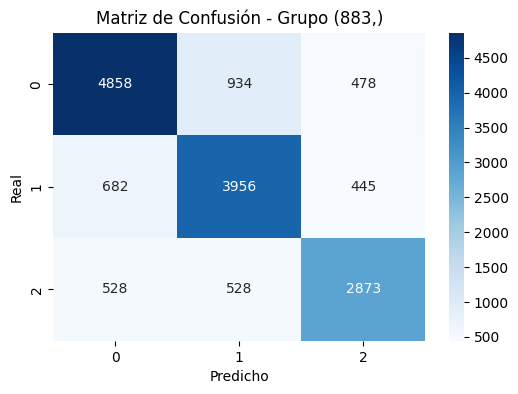


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 6270, np.int64(1): 5083, np.int64(2): 3929})
🔵 Predichos: Counter({np.int64(0): 6068, np.int64(1): 5418, np.int64(2): 3796})

🔍 Primeras 5 predicciones con probabilidades:
[[9.9325353e-01 6.6653169e-03 8.1066355e-05]
 [5.1728395e-05 5.6975248e-04 9.9937856e-01]
 [7.5562978e-01 1.9805847e-01 4.6311796e-02]
 [9.8722154e-01 9.7785508e-03 2.9999868e-03]
 [2.0701601e-01 5.9746173e-03 7.8700942e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(883,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(883,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 154360
🧩 Clases entrenadas: [np.int64(0), np.int64(1), np.int64(2)]
🎯 Accuracy test: 0.7916
────────────────────────────────────────────

🟨 Procesando grupo: (936,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(936,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.19174 | val_0_accuracy: 0.40395 |  0:00:03s
epoch 1  | loss: 2.85581 | val_0_accuracy: 0.38808 |  0:00:06s
epoch 2  | loss: 2.80001 | val_0_accuracy: 0.39916 |  0:00:09s
epoch 3  | loss: 2.69013 | val_0_accuracy: 0.40254 |  0:00:12s
epoch 4  | loss: 2.65838 | val_0_accuracy: 0.39936 |  0:00:15s
epoch 5  | loss: 2.55413 | val_0_accuracy: 0.41499 |  0:00:19s
epoch 6  | loss: 2.47109 | val_0_accuracy: 0.41448 |  0:00:22s
epoch 7  | loss: 2.38904 | val_0_accuracy: 0.3994  |  0:00:25s
epoch 8  | loss: 2.26472 | val_0_accuracy: 0.43023 |  0:00:28s
epoch 9  | loss: 2.16135 | val_0_accuracy: 0.4298  |  0:00:31s
epoch 10 | loss: 2.08329 | val_0_accuracy: 0.42764 |  0:00:34s
epoch 11 | loss: 2.01337 | val_0_accuracy: 0.44406 |  0:00:38s
epoch 12 | loss: 1.95264 | val_0_accuracy: 0.44756 |  0:00:41s
epoch 13 | loss: 1.92526 | val_0_accuracy: 0.44716 |  0:00:44s
epoch 14 | loss: 1.85658 | val_0_accuracy: 0.46331 |  0:00:47s
epoch 15 | loss: 1.75753 | val_0_accuracy: 0.47278 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.78348

✅ Precisión en test para grupo (936,): 0.81733

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      5909
           2       0.77      0.79      0.78      1265
           3       0.77      0.78      0.78      5365

    accuracy                           0.78     12539
   macro avg       0.78      0.78      0.78     12539
weighted avg       0.78      0.78      0.78     12539


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80 1342.7132137199687
           2       0.89      0.78      0.83 453.6406728858884
           3       0.82      0.85      0.83 1551.0158955205422

    accuracy                           0.82 3347.3697821263995
   macro avg       0.83      0.81      0.82 3347.3697821263995
weighted avg       0.82      0.82      0.82 3347.3697821263995



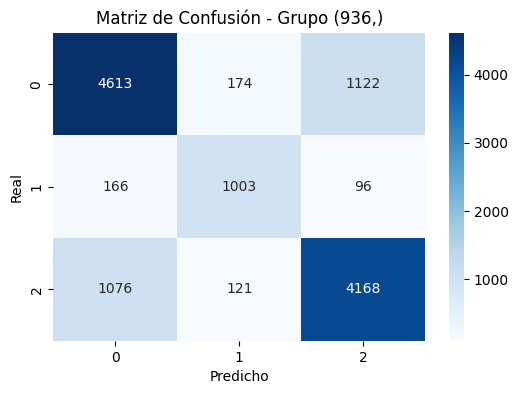


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5909, np.int64(3): 5365, np.int64(2): 1265})
🔵 Predichos: Counter({np.int64(0): 5855, np.int64(3): 5386, np.int64(2): 1298})

🔍 Primeras 5 predicciones con probabilidades:
[[7.9304981e-01 1.6441166e-02 1.9050901e-01]
 [6.7259687e-01 3.6514372e-02 2.9088876e-01]
 [7.6478612e-01 3.4940742e-02 2.0027308e-01]
 [1.9308159e-01 3.4375503e-04 8.0657464e-01]
 [2.8405815e-01 2.0747148e-02 6.9519466e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(936,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(936,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 126649
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8173
────────────────────────────────────────────

🟨 Procesando grupo: (948,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(948,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.40493 | val_0_accuracy: 0.32864 |  0:00:03s
epoch 1  | loss: 2.99889 | val_0_accuracy: 0.32535 |  0:00:07s
epoch 2  | loss: 2.87616 | val_0_accuracy: 0.3328  |  0:00:11s
epoch 3  | loss: 2.76264 | val_0_accuracy: 0.34637 |  0:00:15s
epoch 4  | loss: 2.69892 | val_0_accuracy: 0.35491 |  0:00:19s
epoch 5  | loss: 2.63668 | val_0_accuracy: 0.35395 |  0:00:22s
epoch 6  | loss: 2.59677 | val_0_accuracy: 0.34647 |  0:00:26s
epoch 7  | loss: 2.5398  | val_0_accuracy: 0.35092 |  0:00:30s
epoch 8  | loss: 2.5758  | val_0_accuracy: 0.3602  |  0:00:34s
epoch 9  | loss: 2.54292 | val_0_accuracy: 0.36439 |  0:00:38s
epoch 10 | loss: 2.37693 | val_0_accuracy: 0.37523 |  0:00:41s
epoch 11 | loss: 2.21362 | val_0_accuracy: 0.39638 |  0:00:45s
epoch 12 | loss: 2.07655 | val_0_accuracy: 0.39159 |  0:00:49s
epoch 13 | loss: 1.96273 | val_0_accuracy: 0.4153  |  0:00:52s
epoch 14 | loss: 1.91524 | val_0_accuracy: 0.4159  |  0:00:56s
epoch 15 | loss: 1.79192 | val_0_accuracy: 0.42821 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.77217

✅ Precisión en test para grupo (948,): 0.78860

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.91      0.73      0.81      5383
           2       0.65      0.84      0.73      4097
           3       0.76      0.75      0.75      5332

    accuracy                           0.77     14812
   macro avg       0.78      0.77      0.77     14812
weighted avg       0.79      0.77      0.77     14812


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.88      0.76      0.82 577.6432476698325
           2       0.77      0.83      0.80 855.8947501254924
           3       0.74      0.75      0.74 597.653401802141

    accuracy                           0.79 2031.191399597466
   macro avg       0.80      0.78      0.79 2031.191399597466
weighted avg       0.79      0.79      0.79 2031.191399597466



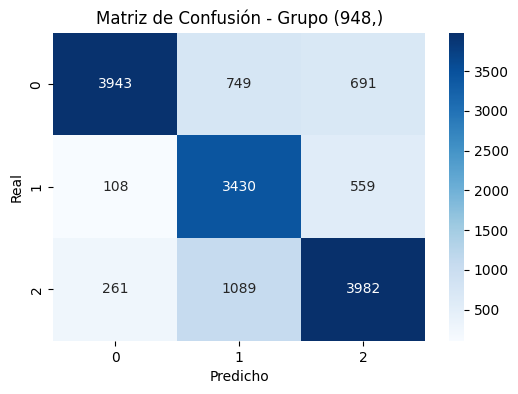


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 5383, np.int64(3): 5332, np.int64(2): 4097})
🔵 Predichos: Counter({np.int64(2): 5268, np.int64(3): 5232, np.int64(1): 4312})

🔍 Primeras 5 predicciones con probabilidades:
[[4.7961766e-01 1.7908096e-01 3.4130138e-01]
 [9.9996614e-01 2.6727819e-05 7.0943547e-06]
 [9.2636526e-02 6.5290326e-01 2.5446019e-01]
 [9.9889058e-01 7.2170072e-04 3.8769952e-04]
 [6.3497297e-02 7.2440326e-01 2.1209946e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(948,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(948,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 149613
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7886
────────────────────────────────────────────

🟨 Procesando grupo: (960,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(960,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.36803 | val_0_accuracy: 0.37085 |  0:00:03s
epoch 1  | loss: 2.99789 | val_0_accuracy: 0.36428 |  0:00:07s
epoch 2  | loss: 2.89467 | val_0_accuracy: 0.37397 |  0:00:10s
epoch 3  | loss: 2.79105 | val_0_accuracy: 0.35306 |  0:00:14s
epoch 4  | loss: 2.73694 | val_0_accuracy: 0.3507  |  0:00:18s
epoch 5  | loss: 2.65485 | val_0_accuracy: 0.36994 |  0:00:21s
epoch 6  | loss: 2.54236 | val_0_accuracy: 0.3813  |  0:00:25s
epoch 7  | loss: 2.41875 | val_0_accuracy: 0.40096 |  0:00:28s
epoch 8  | loss: 2.36976 | val_0_accuracy: 0.39981 |  0:00:32s
epoch 9  | loss: 2.26815 | val_0_accuracy: 0.39547 |  0:00:35s
epoch 10 | loss: 2.21597 | val_0_accuracy: 0.42673 |  0:00:39s
epoch 11 | loss: 2.15995 | val_0_accuracy: 0.4177  |  0:00:43s
epoch 12 | loss: 2.10627 | val_0_accuracy: 0.41641 |  0:00:46s
epoch 13 | loss: 2.03221 | val_0_accuracy: 0.42301 |  0:00:50s
epoch 14 | loss: 1.93531 | val_0_accuracy: 0.42822 |  0:00:53s
epoch 15 | loss: 1.83681 | val_0_accuracy: 0.43472 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.78293

✅ Precisión en test para grupo (960,): 0.75646

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      3574
           2       0.84      0.78      0.81      5034
           3       0.80      0.81      0.80      5573

    accuracy                           0.79     14181
   macro avg       0.78      0.78      0.78     14181
weighted avg       0.79      0.79      0.79     14181


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.75      0.70      0.73 559.3276278725451
           2       0.76      0.80      0.78 631.4241372812952
           3       0.76      0.77      0.76 561.2001648721256

    accuracy                           0.76 1751.9519300259658
   macro avg       0.76      0.75      0.76 1751.9519300259658
weighted avg       0.76      0.76      0.76 1751.9519300259658



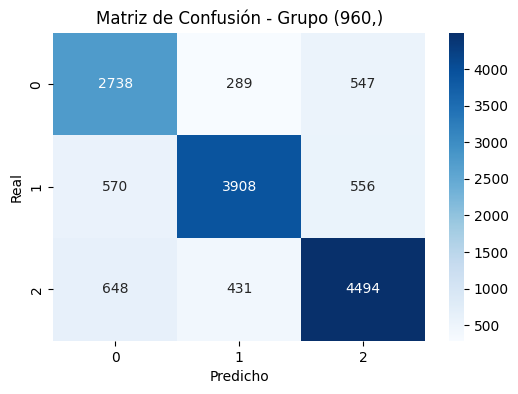


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 5573, np.int64(2): 5034, np.int64(0): 3574})
🔵 Predichos: Counter({np.int64(3): 5597, np.int64(2): 4628, np.int64(0): 3956})

🔍 Primeras 5 predicciones con probabilidades:
[[1.1608555e-04 9.9987209e-01 1.1819324e-05]
 [3.8445768e-01 2.9205617e-01 3.2348612e-01]
 [1.4719211e-01 1.2799485e-01 7.2481310e-01]
 [4.7234303e-01 1.9005738e-01 3.3759958e-01]
 [5.7743901e-01 7.5421385e-02 3.4713960e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(960,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(960,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 143239
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7565
────────────────────────────────────────────

🟨 Procesando grupo: (972,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(972,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.99384 | val_0_accuracy: 0.31831 |  0:00:03s
epoch 1  | loss: 3.5996  | val_0_accuracy: 0.32441 |  0:00:05s
epoch 2  | loss: 3.19839 | val_0_accuracy: 0.32483 |  0:00:09s
epoch 3  | loss: 3.10239 | val_0_accuracy: 0.31579 |  0:00:11s
epoch 4  | loss: 2.94579 | val_0_accuracy: 0.34807 |  0:00:14s
epoch 5  | loss: 2.9408  | val_0_accuracy: 0.35362 |  0:00:17s
epoch 6  | loss: 2.86935 | val_0_accuracy: 0.33559 |  0:00:20s
epoch 7  | loss: 2.83443 | val_0_accuracy: 0.33588 |  0:00:23s
epoch 8  | loss: 2.79255 | val_0_accuracy: 0.34501 |  0:00:26s
epoch 9  | loss: 2.6719  | val_0_accuracy: 0.35472 |  0:00:29s
epoch 10 | loss: 2.55157 | val_0_accuracy: 0.32718 |  0:00:32s
epoch 11 | loss: 2.45268 | val_0_accuracy: 0.3461  |  0:00:35s
epoch 12 | loss: 2.37237 | val_0_accuracy: 0.35484 |  0:00:38s
epoch 13 | loss: 2.33558 | val_0_accuracy: 0.35417 |  0:00:41s
epoch 14 | loss: 2.2996  | val_0_accuracy: 0.34349 |  0:00:44s
epoch 15 | loss: 2.25256 | val_0_accuracy: 0.36943 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.74037

✅ Precisión en test para grupo (972,): 0.81951

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.81      0.72      0.76      4286
           2       0.71      0.77      0.74      3447
           3       0.70      0.74      0.72      3984

    accuracy                           0.74     11717
   macro avg       0.74      0.74      0.74     11717
weighted avg       0.74      0.74      0.74     11717


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.84      0.77      0.80 541.0942217411884
           2       0.81      0.84      0.83 875.4101414252116
           3       0.81      0.83      0.82 863.8997240230728

    accuracy                           0.82 2280.404087189473
   macro avg       0.82      0.81      0.82 2280.404087189473
weighted avg       0.82      0.82      0.82 2280.404087189473



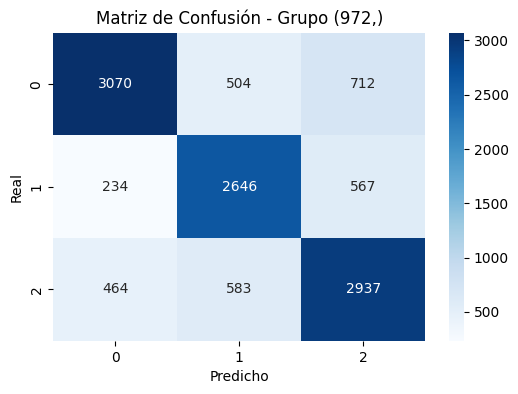


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(1): 4286, np.int64(3): 3984, np.int64(2): 3447})
🔵 Predichos: Counter({np.int64(3): 4216, np.int64(1): 3768, np.int64(2): 3733})

🔍 Primeras 5 predicciones con probabilidades:
[[3.5018288e-06 9.9973887e-01 2.5766899e-04]
 [8.1873178e-02 1.1250580e-03 9.1700172e-01]
 [9.9919933e-01 7.8563578e-04 1.5004483e-05]
 [3.4667608e-01 2.1009098e-01 4.4323298e-01]
 [4.0125633e-03 9.7671425e-01 1.9273156e-02]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(972,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(972,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 118349
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8195
────────────────────────────────────────────

🟨 Procesando grupo: (984,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(984,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.64723 | val_0_accuracy: 0.34763 |  0:00:03s
epoch 1  | loss: 3.18845 | val_0_accuracy: 0.34602 |  0:00:06s
epoch 2  | loss: 2.89627 | val_0_accuracy: 0.33653 |  0:00:09s
epoch 3  | loss: 2.71841 | val_0_accuracy: 0.34941 |  0:00:12s
epoch 4  | loss: 2.68909 | val_0_accuracy: 0.35159 |  0:00:15s
epoch 5  | loss: 2.57384 | val_0_accuracy: 0.35659 |  0:00:19s
epoch 6  | loss: 2.4303  | val_0_accuracy: 0.371   |  0:00:22s
epoch 7  | loss: 2.35689 | val_0_accuracy: 0.35445 |  0:00:25s
epoch 8  | loss: 2.34692 | val_0_accuracy: 0.36018 |  0:00:28s
epoch 9  | loss: 2.24488 | val_0_accuracy: 0.36478 |  0:00:31s
epoch 10 | loss: 2.16405 | val_0_accuracy: 0.38068 |  0:00:34s
epoch 11 | loss: 2.12502 | val_0_accuracy: 0.38306 |  0:00:38s
epoch 12 | loss: 2.0132  | val_0_accuracy: 0.38855 |  0:00:41s
epoch 13 | loss: 2.0131  | val_0_accuracy: 0.40404 |  0:00:44s
epoch 14 | loss: 1.96804 | val_0_accuracy: 0.40299 |  0:00:47s
epoch 15 | loss: 1.86575 | val_0_accuracy: 0.42979 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.75990

✅ Precisión en test para grupo (984,): 0.79304

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.83      0.70      0.76      4339
           2       0.69      0.75      0.72      3485
           3       0.76      0.83      0.79      4383

    accuracy                           0.76     12207
   macro avg       0.76      0.76      0.76     12207
weighted avg       0.77      0.76      0.76     12207


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.78      0.75      0.77 441.18426647995443
           2       0.76      0.74      0.75 768.2605697970129
           3       0.82      0.86      0.84 956.0616782683281

    accuracy                           0.79 2165.5065145452954
   macro avg       0.79      0.78      0.78 2165.5065145452954
weighted avg       0.79      0.79      0.79 2165.5065145452954



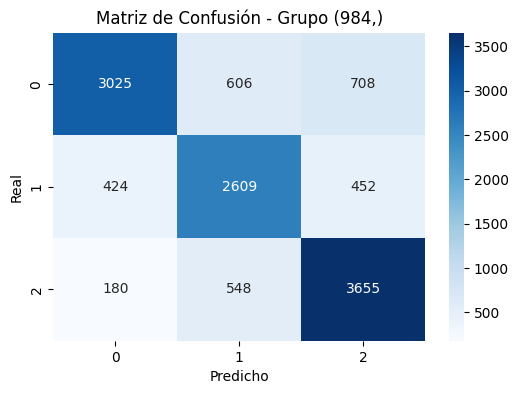


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 4383, np.int64(1): 4339, np.int64(2): 3485})
🔵 Predichos: Counter({np.int64(3): 4815, np.int64(2): 3763, np.int64(1): 3629})

🔍 Primeras 5 predicciones con probabilidades:
[[3.3454543e-01 3.0278400e-04 6.6515172e-01]
 [1.3634089e-01 7.2631067e-01 1.3734843e-01]
 [8.1603624e-02 1.4711972e-04 9.1824925e-01]
 [9.3072814e-01 6.8726711e-02 5.4514932e-04]
 [1.4741948e-01 8.5076100e-01 1.8195527e-03]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(984,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(984,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 123295
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7930
────────────────────────────────────────────

🟨 Procesando grupo: (996,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(996,).pkl
📊 Clases únicas en y_train: 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.85572 | val_0_accuracy: 0.35063 |  0:00:03s
epoch 1  | loss: 3.51591 | val_0_accuracy: 0.34886 |  0:00:06s
epoch 2  | loss: 3.26378 | val_0_accuracy: 0.34488 |  0:00:10s
epoch 3  | loss: 3.19941 | val_0_accuracy: 0.33261 |  0:00:13s
epoch 4  | loss: 3.1402  | val_0_accuracy: 0.33327 |  0:00:17s
epoch 5  | loss: 3.0344  | val_0_accuracy: 0.3231  |  0:00:20s
epoch 6  | loss: 2.97321 | val_0_accuracy: 0.34252 |  0:00:23s
epoch 7  | loss: 2.83589 | val_0_accuracy: 0.34827 |  0:00:27s
epoch 8  | loss: 2.73172 | val_0_accuracy: 0.36323 |  0:00:30s
epoch 9  | loss: 2.70984 | val_0_accuracy: 0.35966 |  0:00:34s
epoch 10 | loss: 2.53915 | val_0_accuracy: 0.35649 |  0:00:37s
epoch 11 | loss: 2.45145 | val_0_accuracy: 0.38793 |  0:00:40s
epoch 12 | loss: 2.24171 | val_0_accuracy: 0.3678  |  0:00:44s
epoch 13 | loss: 2.07851 | val_0_accuracy: 0.38531 |  0:00:47s
epoch 14 | loss: 1.9781  | val_0_accuracy: 0.38741 |  0:00:51s
epoch 15 | loss: 1.84943 | val_0_accuracy: 0.39404 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.73736

✅ Precisión en test para grupo (996,): 0.76132

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      4039
           2       0.80      0.75      0.77      5289
           3       0.71      0.72      0.71      4037

    accuracy                           0.74     13365
   macro avg       0.73      0.74      0.74     13365
weighted avg       0.74      0.74      0.74     13365


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.70      0.74      0.72 634.0626115876001
           2       0.76      0.77      0.76 649.5563390727029
           3       0.81      0.77      0.79 901.722357007306

    accuracy                           0.76 2185.3413076676093
   macro avg       0.76      0.76      0.76 2185.3413076676093
weighted avg       0.76      0.76      0.76 2185.3413076676093



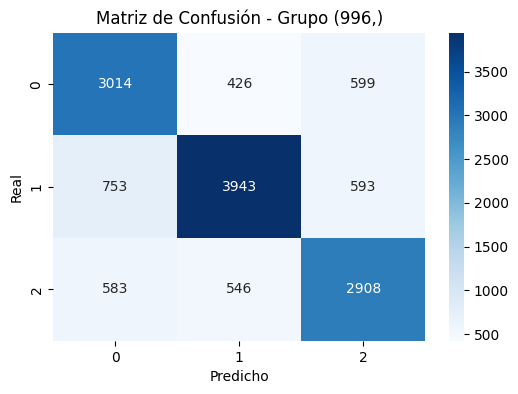


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 5289, np.int64(0): 4039, np.int64(3): 4037})
🔵 Predichos: Counter({np.int64(2): 4915, np.int64(0): 4350, np.int64(3): 4100})

🔍 Primeras 5 predicciones con probabilidades:
[[3.37637365e-01 5.04374802e-01 1.57987863e-01]
 [1.07915641e-03 9.95742619e-01 3.17824725e-03]
 [7.56320357e-01 1.38231993e-01 1.05447635e-01]
 [5.72934091e-01 2.19731688e-01 2.07334235e-01]
 [2.71593109e-02 9.72692609e-01 1.48086241e-04]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(996,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(996,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 134994
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7613
────────────────────────────────────────────

🟨 Procesando grupo: (1008,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(1008,).pkl
📊 Clases ún

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.68855 | val_0_accuracy: 0.32414 |  0:00:03s
epoch 1  | loss: 3.23393 | val_0_accuracy: 0.31988 |  0:00:06s
epoch 2  | loss: 3.03734 | val_0_accuracy: 0.30298 |  0:00:09s
epoch 3  | loss: 2.98538 | val_0_accuracy: 0.32807 |  0:00:12s
epoch 4  | loss: 2.92951 | val_0_accuracy: 0.31896 |  0:00:15s
epoch 5  | loss: 2.86712 | val_0_accuracy: 0.33109 |  0:00:18s
epoch 6  | loss: 2.77816 | val_0_accuracy: 0.3394  |  0:00:21s
epoch 7  | loss: 2.77092 | val_0_accuracy: 0.35758 |  0:00:25s
epoch 8  | loss: 2.5579  | val_0_accuracy: 0.35228 |  0:00:28s
epoch 9  | loss: 2.51224 | val_0_accuracy: 0.3638  |  0:00:31s
epoch 10 | loss: 2.44455 | val_0_accuracy: 0.35569 |  0:00:34s
epoch 11 | loss: 2.37274 | val_0_accuracy: 0.35525 |  0:00:37s
epoch 12 | loss: 2.33214 | val_0_accuracy: 0.34024 |  0:00:41s
epoch 13 | loss: 2.28624 | val_0_accuracy: 0.34277 |  0:00:44s
epoch 14 | loss: 2.24033 | val_0_accuracy: 0.35778 |  0:00:47s
epoch 15 | loss: 2.19035 | val_0_accuracy: 0.34357 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.69920

✅ Precisión en test para grupo (1008,): 0.78143

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           1       0.77      0.68      0.72      4048
           2       0.65      0.68      0.66      3922
           3       0.69      0.75      0.72      4299

    accuracy                           0.70     12269
   macro avg       0.70      0.70      0.70     12269
weighted avg       0.70      0.70      0.70     12269


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           1       0.78      0.73      0.76 442.9929729173795
           2       0.78      0.78      0.78 712.7659454276751
           3       0.78      0.81      0.80 721.5940280398463

    accuracy                           0.78 1877.3529463849009
   macro avg       0.78      0.77      0.78 1877.3529463849009
weighted avg       0.78      0.78      0.78 1877.3529463849009



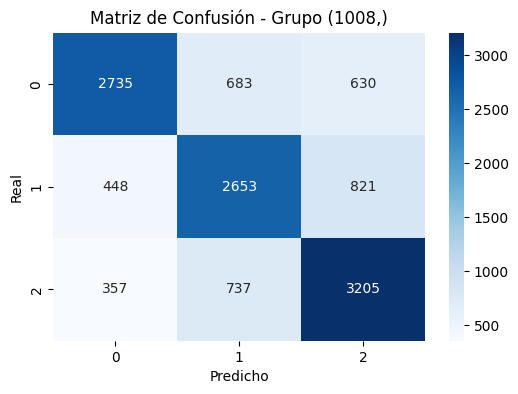


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(3): 4299, np.int64(1): 4048, np.int64(2): 3922})
🔵 Predichos: Counter({np.int64(3): 4656, np.int64(2): 4073, np.int64(1): 3540})

🔍 Primeras 5 predicciones con probabilidades:
[[1.3234270e-01 2.5915554e-02 8.4174174e-01]
 [6.7701258e-02 4.1769218e-01 5.1460660e-01]
 [9.9870026e-01 5.6756584e-05 1.2429719e-03]
 [4.7792375e-02 8.8021535e-01 7.1992278e-02]
 [3.7905119e-02 2.9973266e-01 6.6236222e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(1008,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(1008,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 123924
🧩 Clases entrenadas: [np.int64(1), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7814
────────────────────────────────────────────

🟨 Procesando grupo: (1020,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(1020,).pkl
📊 Clases únicas en y_tra

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.24996 | val_0_accuracy: 0.38997 |  0:00:03s
epoch 1  | loss: 3.08541 | val_0_accuracy: 0.38491 |  0:00:06s
epoch 2  | loss: 2.99226 | val_0_accuracy: 0.37279 |  0:00:09s
epoch 3  | loss: 2.96874 | val_0_accuracy: 0.36449 |  0:00:12s
epoch 4  | loss: 2.90374 | val_0_accuracy: 0.37388 |  0:00:15s
epoch 5  | loss: 2.78698 | val_0_accuracy: 0.37612 |  0:00:18s
epoch 6  | loss: 2.73091 | val_0_accuracy: 0.36866 |  0:00:22s
epoch 7  | loss: 2.66932 | val_0_accuracy: 0.386   |  0:00:25s
epoch 8  | loss: 2.67193 | val_0_accuracy: 0.37901 |  0:00:28s
epoch 9  | loss: 2.62571 | val_0_accuracy: 0.37187 |  0:00:31s
epoch 10 | loss: 2.51463 | val_0_accuracy: 0.38431 |  0:00:34s
epoch 11 | loss: 2.37148 | val_0_accuracy: 0.38828 |  0:00:37s
epoch 12 | loss: 2.30911 | val_0_accuracy: 0.39715 |  0:00:40s
epoch 13 | loss: 2.25838 | val_0_accuracy: 0.4063  |  0:00:44s
epoch 14 | loss: 2.14441 | val_0_accuracy: 0.42741 |  0:00:47s
epoch 15 | loss: 2.05559 | val_0_accuracy: 0.42548 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.80196

✅ Precisión en test para grupo (1020,): 0.83117

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      5559
           2       0.71      0.77      0.74      3966
           3       0.88      0.85      0.87      2750

    accuracy                           0.80     12275
   macro avg       0.81      0.80      0.80     12275
weighted avg       0.80      0.80      0.80     12275


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.80      0.86      0.83 1227.8075968489818
           2       0.81      0.76      0.79 1049.6496778126455
           3       0.93      0.89      0.91 567.1027728042307

    accuracy                           0.83 2844.5600474658577
   macro avg       0.85      0.84      0.84 2844.5600474658577
weighted avg       0.83      0.83      0.83 2844.5600474658577



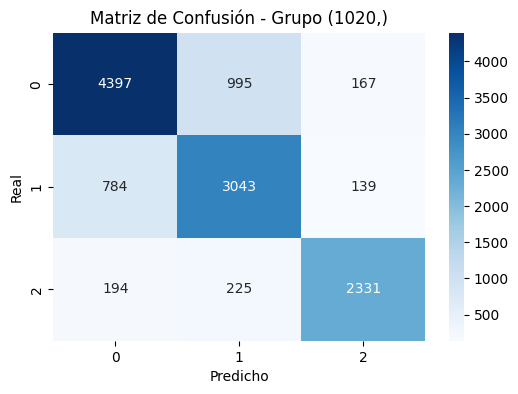


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5559, np.int64(2): 3966, np.int64(3): 2750})
🔵 Predichos: Counter({np.int64(0): 5375, np.int64(2): 4263, np.int64(3): 2637})

🔍 Primeras 5 predicciones con probabilidades:
[[0.8579279  0.08047244 0.06159959]
 [0.874585   0.03402282 0.09139217]
 [0.861323   0.1105805  0.02809655]
 [0.00375994 0.98596686 0.01027324]
 [0.19850153 0.7914855  0.01001297]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(1020,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(1020,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 123981
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8312
────────────────────────────────────────────

🟨 Procesando grupo: (1211,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(1211,).pkl
📊 Clases únicas en y_train: Counter({np.int64(0): 36639, np.int64(2):

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.16491 | val_0_accuracy: 0.33575 |  0:00:03s
epoch 1  | loss: 2.76498 | val_0_accuracy: 0.31903 |  0:00:06s
epoch 2  | loss: 2.63914 | val_0_accuracy: 0.33154 |  0:00:10s
epoch 3  | loss: 2.60696 | val_0_accuracy: 0.33208 |  0:00:13s
epoch 4  | loss: 2.57515 | val_0_accuracy: 0.32664 |  0:00:16s
epoch 5  | loss: 2.47029 | val_0_accuracy: 0.35063 |  0:00:19s
epoch 6  | loss: 2.43054 | val_0_accuracy: 0.36109 |  0:00:23s
epoch 7  | loss: 2.3243  | val_0_accuracy: 0.35611 |  0:00:26s
epoch 8  | loss: 2.28522 | val_0_accuracy: 0.37295 |  0:00:29s
epoch 9  | loss: 2.19483 | val_0_accuracy: 0.38079 |  0:00:33s
epoch 10 | loss: 2.08362 | val_0_accuracy: 0.39474 |  0:00:36s
epoch 11 | loss: 2.0441  | val_0_accuracy: 0.39319 |  0:00:39s
epoch 12 | loss: 1.99256 | val_0_accuracy: 0.40073 |  0:00:42s
epoch 13 | loss: 1.9089  | val_0_accuracy: 0.40737 |  0:00:46s
epoch 14 | loss: 1.84153 | val_0_accuracy: 0.41486 |  0:00:49s
epoch 15 | loss: 1.78368 | val_0_accuracy: 0.42012 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.87278

✅ Precisión en test para grupo (1211,): 0.87777

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      5182
           2       0.97      0.90      0.93      4386
           3       0.73      0.90      0.81      3183

    accuracy                           0.87     12751
   macro avg       0.86      0.87      0.86     12751
weighted avg       0.88      0.87      0.87     12751


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.82      0.85      0.84 1078.2298758869495
           2       0.95      0.92      0.93 825.7317987619907
           3       0.88      0.87      0.88 1468.6165307004708

    accuracy                           0.88 3372.578205349411
   macro avg       0.88      0.88      0.88 3372.578205349411
weighted avg       0.88      0.88      0.88 3372.578205349411



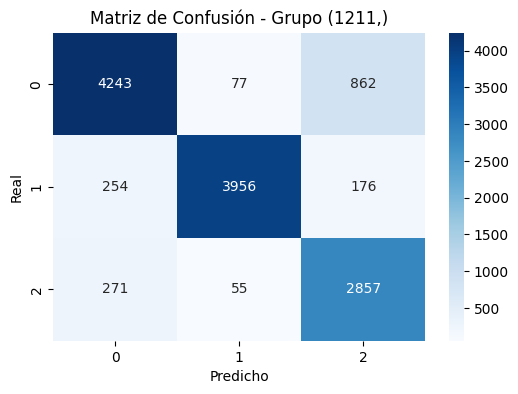


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5182, np.int64(2): 4386, np.int64(3): 3183})
🔵 Predichos: Counter({np.int64(0): 4768, np.int64(2): 4088, np.int64(3): 3895})

🔍 Primeras 5 predicciones con probabilidades:
[[9.4211100e-05 1.7180824e-05 9.9988866e-01]
 [3.5750467e-02 2.4558546e-02 9.3969095e-01]
 [7.2920144e-02 2.0622705e-01 7.2085279e-01]
 [4.7478631e-02 1.4534188e-02 9.3798721e-01]
 [5.4442197e-01 1.5090547e-02 4.4048753e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(1211,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(1211,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 128794
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.8778
────────────────────────────────────────────

🟨 Procesando grupo: (1223,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(1223,).pkl
📊 Clases únicas en y_tra

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.57984 | val_0_accuracy: 0.32488 |  0:00:03s
epoch 1  | loss: 3.26059 | val_0_accuracy: 0.37277 |  0:00:06s
epoch 2  | loss: 3.08177 | val_0_accuracy: 0.39585 |  0:00:09s
epoch 3  | loss: 2.94683 | val_0_accuracy: 0.38255 |  0:00:12s
epoch 4  | loss: 2.83476 | val_0_accuracy: 0.39135 |  0:00:15s
epoch 5  | loss: 2.77906 | val_0_accuracy: 0.38282 |  0:00:18s
epoch 6  | loss: 2.73268 | val_0_accuracy: 0.3955  |  0:00:21s
epoch 7  | loss: 2.64756 | val_0_accuracy: 0.40137 |  0:00:25s
epoch 8  | loss: 2.53194 | val_0_accuracy: 0.38322 |  0:00:28s
epoch 9  | loss: 2.5165  | val_0_accuracy: 0.40387 |  0:00:31s
epoch 10 | loss: 2.40457 | val_0_accuracy: 0.40469 |  0:00:34s
epoch 11 | loss: 2.34103 | val_0_accuracy: 0.40665 |  0:00:37s
epoch 12 | loss: 2.21801 | val_0_accuracy: 0.40462 |  0:00:41s
epoch 13 | loss: 2.15131 | val_0_accuracy: 0.41643 |  0:00:44s
epoch 14 | loss: 2.05085 | val_0_accuracy: 0.42727 |  0:00:47s
epoch 15 | loss: 1.96141 | val_0_accuracy: 0.43169 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.70657

✅ Precisión en test para grupo (1223,): 0.76414

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2698
           2       0.72      0.81      0.76      5751
           3       0.73      0.65      0.69      4141

    accuracy                           0.73     12590
   macro avg       0.73      0.71      0.72     12590
weighted avg       0.73      0.73      0.72     12590


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.82      0.69      0.75 1216.0002123833697
           2       0.72      0.80      0.76 1611.4733980281014
           3       0.78      0.79      0.78 1308.2819190897862

    accuracy                           0.76 4135.755529501257
   macro avg       0.77      0.76      0.76 4135.755529501257
weighted avg       0.77      0.76      0.76 4135.755529501257



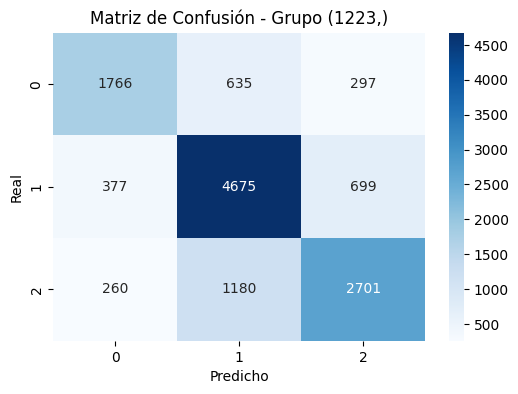


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 5751, np.int64(3): 4141, np.int64(0): 2698})
🔵 Predichos: Counter({np.int64(2): 6490, np.int64(3): 3697, np.int64(0): 2403})

🔍 Primeras 5 predicciones con probabilidades:
[[1.6501626e-01 3.5141197e-01 4.8357180e-01]
 [3.2228604e-01 3.9624226e-01 2.8147173e-01]
 [2.1838897e-01 7.8160232e-01 8.6460586e-06]
 [6.1105266e-02 8.4129697e-01 9.7597755e-02]
 [2.9360212e-03 5.3411514e-01 4.6294883e-01]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(1223,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(1223,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 127164
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7641
────────────────────────────────────────────

🟨 Procesando grupo: (1259,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(1259,).pkl
📊 Clases únicas en y_tra

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.33491 | val_0_accuracy: 0.35287 |  0:00:02s
epoch 1  | loss: 3.06873 | val_0_accuracy: 0.33958 |  0:00:06s
epoch 2  | loss: 2.96706 | val_0_accuracy: 0.36834 |  0:00:09s
epoch 3  | loss: 2.84995 | val_0_accuracy: 0.36678 |  0:00:12s
epoch 4  | loss: 2.76525 | val_0_accuracy: 0.37291 |  0:00:15s
epoch 5  | loss: 2.61354 | val_0_accuracy: 0.3539  |  0:00:18s
epoch 6  | loss: 2.5482  | val_0_accuracy: 0.36406 |  0:00:21s
epoch 7  | loss: 2.48634 | val_0_accuracy: 0.369   |  0:00:24s
epoch 8  | loss: 2.4134  | val_0_accuracy: 0.39596 |  0:00:27s
epoch 9  | loss: 2.34825 | val_0_accuracy: 0.39966 |  0:00:30s
epoch 10 | loss: 2.25502 | val_0_accuracy: 0.40645 |  0:00:33s
epoch 11 | loss: 2.23072 | val_0_accuracy: 0.40658 |  0:00:36s
epoch 12 | loss: 2.1103  | val_0_accuracy: 0.40983 |  0:00:39s
epoch 13 | loss: 2.01671 | val_0_accuracy: 0.43382 |  0:00:42s
epoch 14 | loss: 1.93856 | val_0_accuracy: 0.44403 |  0:00:45s
epoch 15 | loss: 1.865   | val_0_accuracy: 0.43979 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.70805

✅ Precisión en test para grupo (1259,): 0.78246

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      2811
           2       0.84      0.66      0.74      4751
           3       0.65      0.85      0.74      4407

    accuracy                           0.72     11969
   macro avg       0.73      0.71      0.71     11969
weighted avg       0.74      0.72      0.72     11969


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.84      0.75      0.79 1117.798800777349
           2       0.82      0.74      0.78 1001.4262022952569
           3       0.72      0.85      0.78 1247.442964227664

    accuracy                           0.78 3366.66796730027
   macro avg       0.79      0.78      0.78 3366.66796730027
weighted avg       0.79      0.78      0.78 3366.66796730027



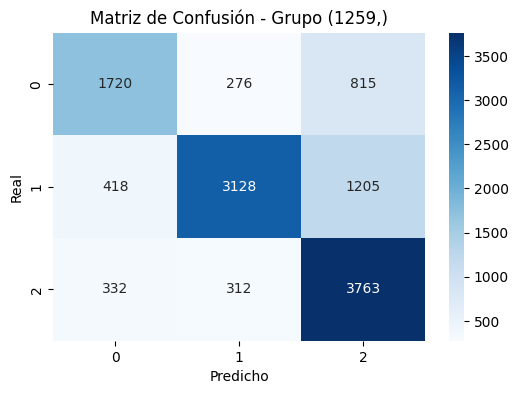


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(2): 4751, np.int64(3): 4407, np.int64(0): 2811})
🔵 Predichos: Counter({np.int64(3): 5783, np.int64(2): 3716, np.int64(0): 2470})

🔍 Primeras 5 predicciones con probabilidades:
[[0.06895709 0.22166367 0.70937926]
 [0.15077002 0.39060998 0.45862004]
 [0.32242742 0.3387225  0.33885008]
 [0.4017047  0.35322583 0.24506949]
 [0.2679583  0.08004798 0.65199375]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(1259,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(1259,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 120887
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7825
────────────────────────────────────────────

🟨 Procesando grupo: (1271,)
✅ Scaler y columnas guardados en: /content/drive/MyDrive/modelos_tabnet_ini_4/scaler_(1271,).pkl
📊 Clases únicas en y_train: Counter({np.int64(0): 36552, np.int64(2):

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.08876 | val_0_accuracy: 0.39131 |  0:00:02s
epoch 1  | loss: 2.94221 | val_0_accuracy: 0.39123 |  0:00:05s
epoch 2  | loss: 2.87002 | val_0_accuracy: 0.39511 |  0:00:08s
epoch 3  | loss: 2.748   | val_0_accuracy: 0.39161 |  0:00:11s
epoch 4  | loss: 2.69977 | val_0_accuracy: 0.38513 |  0:00:14s
epoch 5  | loss: 2.63814 | val_0_accuracy: 0.36791 |  0:00:17s
epoch 6  | loss: 2.64746 | val_0_accuracy: 0.39536 |  0:00:20s
epoch 7  | loss: 2.53747 | val_0_accuracy: 0.37631 |  0:00:23s
epoch 8  | loss: 2.4044  | val_0_accuracy: 0.37192 |  0:00:26s
epoch 9  | loss: 2.39253 | val_0_accuracy: 0.39067 |  0:00:29s
epoch 10 | loss: 2.28814 | val_0_accuracy: 0.39391 |  0:00:32s
epoch 11 | loss: 2.20416 | val_0_accuracy: 0.3986  |  0:00:35s
epoch 12 | loss: 2.11756 | val_0_accuracy: 0.41322 |  0:00:38s
epoch 13 | loss: 2.04137 | val_0_accuracy: 0.40482 |  0:00:41s
epoch 14 | loss: 1.94252 | val_0_accuracy: 0.42119 |  0:00:43s
epoch 15 | loss: 1.94093 | val_0_accuracy: 0.42984 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


⚖️ Balanced Accuracy Score: 0.74572

✅ Precisión en test para grupo (1271,): 0.79574

📋 Reporte sin pesos (clásico):
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      5170
           2       0.58      0.78      0.67      3523
           3       0.90      0.82      0.86      2864

    accuracy                           0.73     11557
   macro avg       0.75      0.75      0.74     11557
weighted avg       0.75      0.73      0.73     11557


📋 Reporte con pesos (ponderado por reward):
              precision    recall  f1-score   support

           0       0.81      0.84      0.82 1281.122643223535
           2       0.76      0.75      0.75 1033.2736199167696
           3       0.83      0.78      0.81 540.4287981237532

    accuracy                           0.80 2854.8250612640577
   macro avg       0.80      0.79      0.79 2854.8250612640577
weighted avg       0.80      0.80      0.80 2854.8250612640577



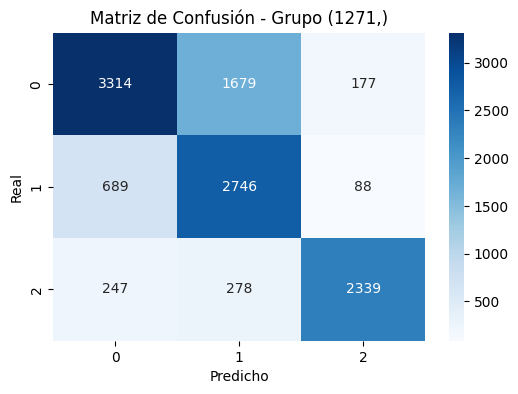


📌 Distribución de movimientos:
🟡 Reales:    Counter({np.int64(0): 5170, np.int64(2): 3523, np.int64(3): 2864})
🔵 Predichos: Counter({np.int64(2): 4703, np.int64(0): 4250, np.int64(3): 2604})

🔍 Primeras 5 predicciones con probabilidades:
[[0.42752752 0.27412573 0.2983468 ]
 [0.10883053 0.8493864  0.04178305]
 [0.19082688 0.32413292 0.4850402 ]
 [0.808541   0.06937391 0.12208511]
 [0.27517548 0.6514935  0.07333098]]
✅ Importancias guardadas en: /content/drive/MyDrive/modelos_tabnet_ini_4/feature_importances_(1271,).json
Successfully saved model at /content/drive/MyDrive/modelos_tabnet_ini_4/tabnet_model_(1271,).zip

📌 Resumen del grupo:
🔢 Nº muestras totales: 116728
🧩 Clases entrenadas: [np.int64(0), np.int64(2), np.int64(3)]
🎯 Accuracy test: 0.7957
────────────────────────────────────────────


In [ ]:
main(grouped_df)